<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/toc-update-P1C2/sequences/P1C2_OptimizationAndEnvironment/P1C2_Sequence3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

____
# **1.2.3: Normative Thinking**

### **Objective:**
Up until this point, we have predominantly viewed optimization as a tool for policy improvement, adapting behavior to better suit a particular environmental niche. This is a prescriptive view of optimization: "To improve the policy, implement these steps." However, optimization isn't solely prescriptive. It can also be used descriptively and predicatively. In this sequence we will learn about using optimization predictively. We call this 'Normative Thinking'.

If we make a series of reasonable assumptions—like behaviour being the result of learning processes which in turn are shaped by evolutionary forces, both of which adapt according to environmental demands—we can posit that the optimal behavior predicted by a model will align with the behaviour exhibited by real-world organisms. Crucially though, the validity of such predictions hinges on the extent to which the ***relevant*** intricacies of the evolutionary organism-environment dynamic are captured by the model.

In this sequence, we will:

* Investigate a new foraging scenario where policy performance can be mathematically-derived.

* Use deduction and reasoning to derive policy performance and determine the optimal policy.

* Observe how a simple propose-accept-reject algorithm, unaware of the structure of the problem, converges on the same optimal outcome as our analytical approach.

* Ponder the beauty and potential power of this connection between deductive reasoning about policies and 'empirical' observation. There are many different optimization methods and approaches, but all effective optimization approaches will lead to -mostly- the same place.

* Look at how optimization approaches fit within a broader framework of scientific understanding generally and what the means for neuroscientific understanding.

# Setup

Run the following cell to setup and install the various dependencies and helper functions for this sequence.

In [3]:
# @markdown **Dependencies, Imports and Setup.** You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image, IFrame
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = ['gw_plotting.py', 'gw_board.py', 'gw_game.py',
             'gw_widgets.py', 'gw_NN_RL.py']
#filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C2_S3"




################################################################
# Graph Viz Helper Functions
################################################################


def latex_to_png(latex_str, file_path, dpi, fontsize, figsize):
  """Convert a LaTeX string to a PNG image."""
  fig, ax = plt.subplots(figsize=figsize)
  ax.text(0.5, 0.5, f"${latex_str}$", size=fontsize, ha='center', va='center')
  ax.axis("off")
  #plt.tight_layout()
  plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)
  plt.close()

def add_latex_edge_labels(graph, edge_labels, dpi=150, fontsize=16, figsize=(0.4,0.2)):
  """Add LaTeX-rendered images as edge labels using the dummy node approach."""
  for edge in edge_labels:
    src, dest, latex_str = edge
    if graph.has_edge(src, dest):
      img_path = f"{src}_to_{dest}_{latex_str}.png"
      latex_to_png(latex_str, img_path, dpi=dpi, fontsize=fontsize, figsize=figsize)
      dummy_node_name = f"dummy_{src}_{dest}_{latex_str}"
      graph.add_node(dummy_node_name, shape="box", image=img_path, label="")
      graph.delete_edge(src, dest)
      graph.add_edge(src, dummy_node_name, dir="none", weight=10)
      graph.add_edge(dummy_node_name, dest, dir="forward", weight=10)
  return graph

def set_regular_node_sizes(graph, width=1.0, height=1.0):
  """Set the size of regular nodes (excluding dummy label nodes)."""
  for node in graph.nodes():
    if not node.startswith("dummy"):
      node.attr['width'] = width
      node.attr['height'] = height
  return graph

def create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                            node_colors = {},
                            node_labels = {},
                            output_path="graphviz_output.png", dpi=300,
                            figsize=(0.6, 0.3), fontsize=16):
  """
  Create a graph with given nodes, edges, and LaTeX edge labels, then render and save it.

  Parameters:
    nodes_list (list): List of nodes in the graph.
    edges_list (list): List of edges in the graph.
    latex_edge_labels (list): List of tuples containing edge and its LaTeX label.
    output_path (str): Path to save the rendered graph.
    dpi (int): DPI for rendering the graph.
    figsize (tuple): Figure size for the LaTeX labels.

  Returns:
    str: Path to the saved graph image.
  """

  # Graph Creation and Configuration
  G = pgv.AGraph(directed=True, strict=False, rankdir='LR', ranksep=0.5, nodesep=0.5)
  for node in nodes_list:
    color = node_colors.get(node, "black")
    label = node_labels.get(node, node)
    G.add_node(node, color=color, label=label)
  for edge in edges_list:
    G.add_edge(edge[0], edge[1])

  # Set size for regular nodes and add LaTeX-rendered image labels to the edges
  G = set_regular_node_sizes(G, width=1, height=1)
  G = add_latex_edge_labels(G, latex_edge_labels, dpi=dpi, figsize=figsize, fontsize=fontsize)

  # Additional graph attributes
  G.graph_attr['size'] = "8,8"
  G.graph_attr['dpi'] = str(dpi)

  # Render and save the graph
  G.layout(prog='dot')
  G.draw(output_path)

  return output_path




#######################################################################
# make PatchyForageBoard class locally before integrating in shared utils
#######################################################################




class PatchyForageBoard():
  """
  A collection of methods and parameters of a patchy foraging game board that
  define the logic of the game, and allows for multiple critters on the same
  board

  game state is represented by primarily by food locations, forager locations,
  predator locations, scores, and rounds left
  food patch locations are stored on a batch x n_rows x n_cols numpy array,
  forager and predator(when we have them) locations are stored as dictionaries
  with integer keys corresponding to a forager/predatore 1, 2, 3 etc, and then
  np.argwhere style tuples of arrays of (batch_array, row_array, col_array)
  giving the locations

  scores is a batchsize x num_critters numpy array giving the scores for each
  critter on each board in the batch (note off by one indexing)

  rounds_left is how many rounds are left in the game.

  Note:
    In 2d np.array first dim is row (vertical), second dim is col (horizontal),
    i.e. top left corner is (0,0), so take care when visualizing/plotting
    as np.array visualization inline with typical tensor notation but at odds
    with conventional plotting where (0,0) is bottom left, first dim, x, is
    horizontal, second dim, y, is vertical
  """

  ARRAY_PAD_VALUE = -200

  def __init__(self, batch_size=1,
               n_rows=10, n_cols=5,
               num_foragers=1,
               max_foraging_attempts=20,
               food_patch_prob = 0.4,
               food_regen_prob=0.0,
               forage_success_prob = 0.7,
               food_extinct_prob = 0.1, rng=None):
    """Set the parameters of the game."""
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.batch_size = batch_size
    self.num_foragers = num_foragers
    self.max_foraging_attempts = max_foraging_attempts
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng


  def init_loc(self, n_rows, n_cols, num, rng=None):
    """
    Samples random 2d grid locations without replacement

    Args:
      n_rows: int, number of rows in the grid
      n_cols: int, number of columns in the grid
      num:    int, number of samples to generate. Should throw an error if num > n_rows x n_cols
      rng:    instance of numpy.random's default rng. Used for reproducibility.

    Returns:
      int_loc: ndarray(int) of shape (num,), flat indices for a 2D grid flattened into 1D
      rc_index: tuple(ndarray(int), ndarray(int)), a pair of arrays with the first giving
        the row indices and the second giving the col indices. Useful for indexing into
        an n_rows by n_cols numpy array.
      rc_plotting: ndarray(int) of shape (num, 2), 2D coordinates suitable for matplotlib plotting
    """

    # Set up default random generator, use the boards default if none explicitly given
    if rng is None:
      rng = self.rng
    # Choose 'num' unique random indices from a flat 1D array of size n_rows*n_cols
    int_loc = rng.choice(n_rows * n_cols, num, replace=False)
    # Convert the flat indices to 2D indices based on the original shape (n_rows, n_cols)
    rc_index = np.unravel_index(int_loc, (n_rows, n_cols))
    # Transpose indices to get num x 2 array for easy plotting with matplotlib
    rc_plotting = np.array(rc_index).T
    # Return 1D flat indices, 2D indices for numpy array indexing and 2D indices for plotting
    return int_loc, rc_index, rc_plotting


  def get_init_board_state(self):
    """
    Set up starting board using game parameters

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new
    """
    # note that is_over applies at the batch level not the batch x forager level
    self.is_over = np.zeros(self.batch_size, dtype=bool)
    self.foraging_attempts = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.scores = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    # create an empty board array for food locs
    self.pieces = np.zeros((self.batch_size, self.n_rows, self.n_cols),
                           dtype=int)
    # Place critters in top left corner of the board
    self.forager_locs = {}
    for c in (np.arange(self.num_foragers)+1):
      self.forager_locs[c] = (np.arange(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int),
                              np.zeros(self.batch_size, dtype=int))
    # Initial food patches on the board randomly
    # each grid has an independent prob of being a pathc (to make the math
    # easier later) so total number of patches on a board is binomially
    # distributed
    num_foods = self.rng.binomial(n=self.n_rows * self.n_cols,
                                  p=self.food_patch_prob,
                                  size=self.batch_size)
    for ii in np.arange(self.batch_size):
      int_loc, rc_idx, rc_plot = self.init_loc(self.n_rows, self.n_cols,
                                               num_foods[ii])
      # food patch start locations (do each patch separate in case we
      # want to have different kinds of patches)
      for f_ in np.arange(num_foods[ii]):
        self.pieces[(ii, rc_idx[0][f_],
                         rc_idx[1][f_])] = - 1
    # keep track of which foragers have missed how many times
    # at what kind of patch
    self.misses_new_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.misses_known_patch = np.zeros((self.batch_size, self.num_foragers), dtype=int)
    self.at_new_patch = np.ones((self.batch_size, self.num_foragers), dtype=bool)
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'foraging_attempts': self.foraging_attempts.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  def set_state(self, board):
    """
    Sets the state given a board dictionary.

    Args:
      board (dict):
      The board dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    self.pieces = board['pieces'].copy()
    self.forager_locs = copy.deepcopy(board['forager_locs'])
    self.foraging_attempts = board['foraging_attempts'].copy()
    self.scores = board['scores'].copy()
    self.is_over = board['is_over'].copy()
    self.misses_new_patch = board['misses_new_patch'].copy()
    self.misses_known_patch = board['misses_known_patch'].copy()
    self.at_new_patch = board['at_new_patch'].copy()


  def get_state(self):
    """
    Returns the current board state.

    Returns:
      state (dict):
      The state dictionary contains:
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': Dictionary of current locations of the foragers on the board.
        - 'misses_new_patch': List of counts for missed attempts at new patches for each critter.
        - 'misses_known_patch': List of counts for missed attempts at known patches for each critter.
        - 'at_new_patch': List of booleans indicating if each critter is at a new patch.
    """
    state = {'pieces': self.pieces.copy(),
             'scores': self.scores.copy(),
             'foraging_attempts': self.foraging_attempts.copy(),
             'is_over': self.is_over.copy(),
             'forager_locs': copy.deepcopy(self.forager_locs),
             'misses_new_patch': self.misses_new_patch.copy(),
             'misses_known_patch': self.misses_known_patch.copy(),
             'at_new_patch': self.at_new_patch.copy()}
    return state


  ################# CORE GAME STATE UPDATE LOGIC ##############################
  ################# execute_moves is main, uses these helper functions ########


  def execute_moves(self, moves, which_critter):
    """
    Execute the moves on the board. A move to the current location implies
    foraging. If foraging, check if foraging is successful, update scores,
    and check if the food goes extinct. If moving to a new location, simply
    update the critter's location.

    Args:
      moves (tuple): A tuple of three arrays:
        - batch_array: Specifies which board in the batch the move corresponds to.
        - row_array: Specifies the target row for each move.
        - col_array: Specifies the target column for each move.
        Each array in the tuple has the same length. A move is represented by
        the combination of a batch index, row index, and column index at the
        same position in their respective arrays.
      which_critter (int): Index to identify the critter. Starts from 1.

    Returns: Nothing, just updates state related attributes of the board object

    """
    #expand moves tuple
    batch_moves, row_moves, col_moves = moves

    # Get current locations of the critter
    current_locs = self.forager_locs[which_critter]

    # Iterate over each board in the batch
    for ii in np.arange(self.batch_size):
      # If the game is over for this board, skip
      if self.is_over[ii]:
        continue

      # Get new location directly from the moves
      new_row = int(row_moves[ii])
      new_col = int(col_moves[ii])

      # Check if the critter has moved to a new patch
      if (new_row, new_col) != (current_locs[1][ii], current_locs[2][ii]):
        # Moved to a new patch
        self.misses_new_patch[ii, which_critter - 1] = 0
        self.misses_known_patch[ii, which_critter - 1] = 0
        self.at_new_patch[ii, which_critter - 1] = True

      # If the critter's position has not changed, it's trying to forage
      elif (new_row, new_col) == (current_locs[1][ii], current_locs[2][ii]):
        # increment foraging attempt only if foraging
        self.foraging_attempts[ii, which_critter - 1] += 1
        # Check if there's food at the location
        if self.pieces[ii, new_row, new_col] < 0:
          # Check if foraging is successful
          if self.rng.random() < self.forage_success_prob:
            # Successful foraging, increase critter's score
            self.scores[ii, which_critter - 1] += 1
            # misses are zeroed and no longer at new patch
            self.misses_new_patch[ii, which_critter - 1] = 0
            self.misses_known_patch[ii, which_critter - 1] = 0
            self.at_new_patch[ii, which_critter - 1] = False
            # Check if food goes extinct (only on success)
            if self.rng.random() < self.food_extinct_prob:
              self.pieces[ii, new_row, new_col] = 0  # Set it to empty
          else:
            #unsuccessful foraging at patch with food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1
        else:
          #unsuccessful foraging at patch without food
            if self.at_new_patch[ii, which_critter - 1]:
              # at a new patch
              self.misses_new_patch[ii, which_critter - 1] += 1
            else:
              # at a known patch
              self.misses_known_patch[ii, which_critter - 1] += 1

      # Always check if session is over
      if self.foraging_attempts[ii] >= self.max_foraging_attempts:
        self.is_over[ii] = True

    # assume moves are legal and update locs for whole batch at once
    self.forager_locs[which_critter] = (batch_moves, row_moves, col_moves)

  ###### Getting Legal Moves and Perceptions #########################
  ####################################################################
  def get_neighbor_grc_indices(self, which_critter, radius, pad=False):
    """
    Returns all grid positions within a certain cityblock distance radius from
    the place corresponding to which_critter.

    Args:
        which_critter (int): The idex of the focal critter_food.
        radius (int): The cityblock distance.
        pad (bool): whether or not to pad the array, if padded all row, col
          indexes are valid for the padded array, useful for getting percept
          if not all indexes are correct for the original array, useful for
          figuring out legal moves.

    Returns:
        an array of indices, each row is a g, r, c index for the neighborhoods
        around the critters, can use the g value to know which board you are in.
        if pad=True also returns the padded array (the indices in that case) are
        for the padded array, so won't work on self.pieces, whereas if pad is
        False the indices will be for the offsets in reference to the original
        self.pieces, but note that some of these will be invalid, and will
        need to be filtered out (as we do in get_legal)
    """
    batch_size, n_rows, n_cols = self.pieces.shape
    batch, rows, cols = self.forager_locs[which_critter]
    # Create meshgrid for offsets
    if pad is True:
      padded_arr = np.pad(self.pieces, ((0, 0), (radius, radius),
        (radius, radius)), constant_values=self.ARRAY_PAD_VALUE)
      rows = rows + radius
      cols = cols + radius

    row_offsets, col_offsets = np.meshgrid(
        np.arange(-radius, radius + 1),
        np.arange(-radius, radius + 1),
        indexing='ij')

    # Filter for valid cityblock distances
    mask = np.abs(row_offsets) + np.abs(col_offsets) <= radius
    valid_row_offsets = row_offsets[mask]
    valid_col_offsets = col_offsets[mask]
    # Extend rows and cols dimensions for broadcasting
    extended_rows = rows[:, np.newaxis]
    extended_cols = cols[:, np.newaxis]
    # Compute all neighbors for each position in the batch
    neighbors_rows = extended_rows + valid_row_offsets
    neighbors_cols = extended_cols + valid_col_offsets

    indices = np.column_stack((np.repeat(np.arange(batch_size),
                                         neighbors_rows.shape[1]),
                               neighbors_rows.ravel(),
                               neighbors_cols.ravel()))
    if pad is False:
      return indices
    elif pad is True:
      return indices, padded_arr


  def get_legal_moves(self, which_critter, radius=1):
    """
    Identifies all legal moves for the critter.

    Returns:
      A numpy int array of size batch x 3(g,x,y) x 4(possible moves)

    Note:
      moves[0,1,3] is the x coordinate of the move corresponding to the
      fourth offset on the first board.
      moves[1,:,1] will give the g,x,y triple corresponding to the
      move on the second board and the second offset, actions are integers
    """

    critter_locs = np.array(self.forager_locs[which_critter])
    # turn those row, col offsets into a set of legal offsets
    legal_offsets = self.get_neighbor_grc_indices(which_critter, radius)
    legal_offsets = {tuple(m_) for m_ in legal_offsets}

    legal_destinations = np.where(np.ones(self.pieces.shape, dtype=bool))
    legal_destinations = {tuple(coords) for coords in zip(*legal_destinations)}
    # Add the current locations of the critters to legal_destinations
    current_locations = {tuple(loc) for loc in critter_locs.T}
    legal_destinations = legal_destinations.union(current_locations)

    # legal moves are both legal offsets and legal destinations
    legal_moves = legal_offsets.intersection(legal_destinations)
    return legal_moves


  def get_perceptions(self, critter_food, radius):
    idx, pad_pieces = self.get_neighbor_grc_indices(critter_food,
                                                    radius, pad=True)
    #percept_mask = np.zeros(pad_pieces.shape, dtype=bool)
    #percept_mask[idx[:,0], idx[:,1]], idx[:,2]] = True
    percept = pad_pieces[idx[:,0], idx[:,1], idx[:,2]]
    return(percept.reshape(self.batch_size, -1))




#######################################################################
# make PatchyForageGame class locally before integrating in shared utils
#######################################################################





class PatchyForagingGame():
  """
  A collection of methods and parameters of a patchy foraging game that allow
  for interaction with and display of PatchyForageBoard objects.
  """


  def __init__(self, batch_size=1, n_rows=10, n_cols=5, num_foragers=1,
               max_foraging_attempts=20, food_patch_prob=0.3, food_regen_prob=0.0,
               forage_success_prob=0.6, food_extinct_prob=0.2, rng=None):
    """
    Initializes an instance of the PatchyForagingGame with the specified parameters.
    Args:
    ... [same as in PatchyForageBoard]
    """
    self.batch_size = batch_size
    self.n_rows = n_rows
    self.n_cols = n_cols
    self.num_foragers = num_foragers
    self.max_foraging_attempts = max_foraging_attempts
    self.food_patch_prob = food_patch_prob
    self.forage_success_prob = forage_success_prob
    self.food_extinct_prob = food_extinct_prob
    self.food_regen_prob = food_regen_prob
    if rng is None:
      self.rng = np.random.default_rng(seed=SEED)
    else:
      self.rng = rng

  def get_init_board(self):
    """
    Generates a starting board given the parameters of the game.
    Returns the initial state of the game.
    """
    board = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                              n_cols=self.n_cols, num_foragers=self.num_foragers,
                              max_foraging_attempts=self.max_foraging_attempts, food_patch_prob=self.food_patch_prob,
                              forage_success_prob=self.forage_success_prob,
                              food_extinct_prob=self.food_extinct_prob,
                              food_regen_prob=self.food_regen_prob, rng=self.rng)
    return board.get_init_board_state()


  def get_board_shape(self):
    """Shape of a single board, doesn't give batch size"""
    return (self.n_rows, self.n_cols)

  def get_action_size(self):
    """
    Returns the number of all possible actions, even though only a subset
    of these will ever be valid on a given turn.
    Actions correspond to integer indexes of board locations,
    moves to (batch,) row and column coordinate indexes of board locations.
    """
    return self.n_rows * self.n_cols

  def get_batch_size(self):
    return self.batch_size

  def get_scores(self, board):
    return board['scores'].copy()

  def get_foraging_attempts(self, board):
    return board['foraging_attempts'].copy()

  def get_square_symbol(self, piece, has_forager):
    """Returns the symbol representation of a board square."""
    if has_forager and piece < 0: return 'C'  # Critter on food patch
    if has_forager: return 'P'  # Forager on an empty square
    if piece == 0: return '.'  # Empty square
    if piece < 0: return 'F'  # Food patch
    return '?'  # Unknown piece type, for debugging

  def display(self, board, g=0):
    """Displays the g-th game in the batch of boards."""
    print("   ", end="")
    for c_ in range(self.n_cols):
      print(c_, end=" ")
    print("")
    print("-----------------------")
    for r_ in range(self.n_rows):
      print(r_, "|", end="")  # Print the row number
      for c_ in range(self.n_cols):
        piece = board['pieces'][g, r_, c_]  # Get the piece to print
        # Check if the square is occupied by a forager
        has_forager = False
        for forager_num, locs in board['forager_locs'].items():
          if g in locs[0] and r_ in locs[1] and c_ in locs[2]:
            has_forager = True
            break

        print(self.get_square_symbol(piece, has_forager), end=" ")
      print("|")
    print("-----------------------")
    print("Foraging Attempts: " + str(board['foraging_attempts'][g]))
    print("Score: " + str(board['scores'][g]))

  def get_critter_rc(self, board, g, which_critter):
    critter_locs = board['forager_locs'][which_critter]
    return critter_locs[1][g], critter_locs[2][g]

  def plot_board(self, board, g=0,
                 fig=None, ax=None, critter_specs=None, food=None, fov=None,
                 legend_type='included',
                 has_fov=False, #fog_of_war field_of_view
                 fov_opaque=False, #let human see through fog of war or not
                 show_food=True,
                 radius=2, figsize=(6,5), title=None,
                 name='Critter',
                 focal_critter_index = 0):
    """Uses plotting functions to make picture of the current board state"""
    batch_size, n_rows, n_cols = board['pieces'].shape
    plt.ioff()
    if fig is None and ax is None:
      fig, ax = make_grid(n_rows, n_cols, figsize=figsize, title=title)

    # get food locs and plot them
    rc_food_index = np.array(np.where(board['pieces'][g] <= -1))
    rc_food_plotting = np.array(rc_food_index).T
    if food is None:
      food = plot_food(fig, ax, rc_food_plotting, size=550, show_food=show_food)
    else:
      food = plot_food(fig, ax, rc_food_plotting, food, show_food=show_food)

    # generate critter plotting specs if we don't already have them
    if critter_specs is None:
      critter_specs = []
      markers = ['h', 'd']  # hexagon and diamond
      colors = sns.color_palette("colorblind")
      for i in range(self.num_foragers):
        critter_name = name if self.num_foragers == 1 else f'{name} {i+1}'
        spec = {'marker': markers[i % len(markers)],
                'color': colors[i // len(markers) % len(colors)],
                'name': critter_name,
                'int_id': i+1}
        critter_specs.append(spec)
    # get critter locs and plot them
    assert len(critter_specs) == self.num_foragers, "More/fewer specs than critters"
    for spec in critter_specs:
      rc_loc = np.array(self.get_critter_rc(board, g, spec['int_id'])).T
      spec.update({'rc_loc': rc_loc})
    critter_specs = plot_critters(fig, ax, critter_specs)

    #plot field of view if doing that
    if has_fov:
      # plot field of view around the 'active player'
      if fov is None:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque)
      else:
        fov = plot_fov(fig, ax, critter_specs[focal_critter_index]['rc_loc'][0],
                       n_rows, n_cols, radius, has_fov, opaque=fov_opaque, fov=fov)
    # make legend and draw and return figure
    if legend_type == 'included':
      fig.legend(loc = "outside right upper", markerscale=0.8)
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov
    elif legend_type == 'separate':
      fig_legend, ax_legend = plt.subplots(figsize=(1.5,1.5), layout='constrained')
      fig_legend.get_layout_engine().set(w_pad=0, h_pad=0, hspace=0, wspace=0)
      handles, labels = ax.get_legend_handles_labels()
      ax_legend.legend(handles, labels, loc='center', markerscale=0.8)
      ax_legend.axis('off')
      fig_legend.canvas.header_visible = False
      fig_legend.canvas.toolbar_visible = False
      fig_legend.canvas.resizable = False
      fig_legend.canvas.footer_visible = False
      fig_legend.canvas.draw()
      return fig, ax, critter_specs, food, fov, fig_legend, ax_legend
    else: #no legend
      fig.canvas.draw()
      return fig, ax, critter_specs, food, fov


  def get_legal_moves(self, board, which_critter=1, radius=1):
    """
    A Helper function to get the legal moves, as a set of batch, row, col triples
    for the given board. Does return moves that are technically legal
    but that will result in a blocking move

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.

      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      moves: set or tuples (g, r, c)
    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          max_foraging_attempts=self.max_foraging_attempts,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    legal_moves =  b.get_legal_moves(which_critter, radius)
    return legal_moves

  def get_valid_actions(self, board, which_critter=1, radius=1):
    """
    A Helper function to translate the g,x,y, tuples provided the
    get_legal_moves method into valid actions, represented
    as binary vectors of len num_actions.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter (int): value of critter we are getting the valid actions for
      radius (int): how far, in city block distance the critter can move

    Returns:
      valids: np.ndarray(binary) batch_size x num_actions, 1's represent
              valid moves
    """
    legal_moves =  self.get_legal_moves(board, which_critter, radius)
    g, r, c = zip(*legal_moves)
    valids = np.zeros((self.batch_size, self.n_rows * self.n_cols))
    valids[g, np.array(r) * self.n_cols + np.array(c)] = 1
    return valids


  def get_next_state(self, board, which_critter, actions):
    """
    Helper function using GridworldBoard.execute_moves to update board state
    given actions on a batch of boards, for a given critter

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      actions: list of flat integer indexes of critter's new board positions

    Returns:
      a board triple signifying next state

    Note:
      if len(actions) > batch_size of board the returned board state will have
      an expanded batch size, allowing multiple paths in the game tree to be
      explored in parallel

    """
    batch_size, n_rows, n_cols = board['pieces'].shape
    assert batch_size == len(actions)
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          max_foraging_attempts=self.max_foraging_attempts,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.actions_to_moves(actions)
    b.execute_moves(moves, which_critter)
    return b.get_state()

  def actions_to_moves(self, actions):
    """
    Args:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    Returns
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    """
    moves = (np.arange(len(actions)),
             np.floor_divide(actions, self.n_cols),
             np.remainder(actions, self.n_cols))
    return moves

  def moves_to_actions(self, moves):
    """
    Args:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for quick numpy operations.
    Returns:
      actions: a batch length list of integer indexes for the flattened boards,
      i.e. in the range(n_cols * n_rows) actions are often much easier to use
      as training targets for NN based RL agents.
    """
    _, rows, cols = moves
    actions = rows * self.n_cols + cols
    return actions

  def critter_oriented_get_next_state(self, board, which_critter, offsets):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then get's the next state.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings one 'up', 'down', 'left', 'right' 'still'

    Returns:
      a board triple signifying next state

    Note:
      Unlike get_next_state, this method does not allow for expansion
      of the game tree, i.e. len(offsets)==batch_size required
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          max_foraging_attempts=self.max_foraging_attempts,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    moves = self.critter_direction_to_move(board, offsets, which_critter)
    b.execute_moves(moves, which_critter)
    return(b.get_state())

  def critter_direction_to_move(self, board, offsets, critter):
    """
    Translates directions in reference to the critter's location into
    moves on the board in absolute terms, while checking for
    bouncing/reflecting then returns moves. Doesn't check for collisions with
    other critters though. In general player's move methods should be checking
    valid moves and only making legal ones.

    Args:
      board: a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      which_critter: integer index of the critter type
      offsets: batch length list of strings,
        one of 'up', 'down', 'left', 'right', 'still'

    Returns:
      moves: a 3-tuple of 1-d arrays each of length batch_size,
        the first array gives the specific board within the batch,
        the second array in the tuple gives the new row coord for each critter
        on each board and the third gives the new col coord. Note this is
        exactly the format expected by GridworldBoard.execute_moves, and
        is a canonical way of indexing arrays for numpy.
    """
    assert len(offsets) == board['pieces'].shape[0]
    batch_size, n_rows, n_cols = board['pieces'].shape
    offset_dict = {'up': (0, -1, 0),
                   'down': (0, 1, 0),
                   'left': (0, 0, -1),
                   'right': (0, 0, 1),
                   'still': (0, 0, 0)}
    this_critter_locs = board['forager_locs'][critter]
    all_critter_locs = np.where(board['pieces'] >= 1)
    offsets_array = np.hstack([np.array(offset_dict[ost_]).reshape((3,1))
                           for ost_ in offsets])
    new_locs = np.array(this_critter_locs) + offsets_array
    #check bounces at boundaries
    new_locs[1,:] = np.where(new_locs[1] >=
                               n_rows, n_rows-2, new_locs[1])
    new_locs[2,:] = np.where(new_locs[2,:] >=
                               n_cols, n_cols-2, new_locs[2,:])
    new_locs[1,:] = np.where(new_locs[1,:] < 0, 1, new_locs[1,:])
    new_locs[2,:] = np.where(new_locs[2,:] < 0, 1, new_locs[2,:])
    moves = tuple(new_locs)
    return moves

  def critter_directions_to_actions(self, board, directions, critter):
    """
    Converts a list of direction strings to a list of action indices for the given board state and critter.

    Args:
      board (dict): The current state of the game.
      directions (list of str): List of directions, where each direction is one of 'up', 'down', 'left', 'right', 'still'.
      critter (int): The critter index.

    Returns:
      list of int: List of action indices corresponding to the directions.
    """
    # Ensure the length of directions matches the batch size
    assert len(directions) == board['pieces'].shape[0], "Mismatch between directions length and batch size"

    # Convert directions to moves
    moves = self.critter_direction_to_move(board, directions, critter)

    # Convert moves to actions
    actions = self.moves_to_actions(moves)

    return actions


  def get_valid_directions(self, board, which_critter):
    """
    Transforms output of get_valid_actions to a list of the valid directions
    for each board in the batch for a given critter.
    """
    offset_dict = {( 0, 1): 'right',
                   ( 0,-1): 'left',
                   ( 1, 0): 'down',
                   (-1, 0): 'up',
                   ( 0, 0): 'still'}
    batch_size, n_rows, n_cols = board['pieces'].shape
    valid_actions = self.get_valid_actions(board, which_critter)
    if batch_size != len(valid_actions):
      raise ValueError("Need Exactly one set of valid actions per board in batch")
    critter_locs = board['forager_locs'][which_critter]
    valid_directions = []
    for g, batch_valid in enumerate(valid_actions):
      valid_int_indices = np.where(batch_valid==1)[0]
      critter_loc = np.array([[critter_locs[1][g],critter_locs[2][g]]])
      # critter_loc shape is (1, 2)
      moves = np.column_stack([valid_int_indices // n_cols, valid_int_indices % n_cols])
      offsets = moves - critter_loc
      batch_valid_directions = [offset_dict[tuple(offset)] for offset in offsets]
      valid_directions.append(batch_valid_directions)
    return valid_directions


  def get_perceptions(self, board, radius, which_critter):
    batch_size, n_rows, n_cols = board['pieces'].shape
    b = PatchyForageBoard(batch_size=self.batch_size, n_rows=self.n_rows,
                          n_cols=self.n_cols, num_foragers=self.num_foragers,
                          max_foraging_attempts=self.max_foraging_attempts,
                          food_patch_prob=self.food_patch_prob,
                          forage_success_prob=self.forage_success_prob,
                          food_extinct_prob=self.food_extinct_prob,
                          food_regen_prob=self.food_regen_prob, rng=self.rng)
    b.set_state(board)
    return(b.get_perceptions(radius, which_critter))


  def play_game(self, players=[], visualize = False):
    """This method takes a list of players the same length as num_foragers,
        and then plays a batch of games with them and returns the final board
        states of each game"""
    if len(players) != self.num_foragers:
      raise ValueError("number of players different than expected")

    board = self.get_init_board()
    if visualize == True:
      self.display(board, 0)

    for p_idx, player_ in enumerate(players):
      if player_.critter_index != p_idx+1:
        print(player_.critter_index)
        print(p_idx + 1)
        raise ValueError("player order does not match assigned critter index")

    while np.any(board['is_over'] == False):
      for player_ in players:
        old_scores = board['scores']
        if player_.return_direction:
          directions = player_.play(board)
          a_player = self.critter_directions_to_actions(board, directions, player_.critter_index)
        else: # player returns actions directly
          a_player, _, _ = player_.play(board)
        board = self.get_next_state(board, player_.critter_index, a_player)
        if visualize == True:
          self.display(board, 0)
    return board


  def plot_visualizations(board):
    # Extracting scores and foraging_attempts for all batches
    scores = board['scores']
    foraging_attempts = board['foraging_attempts']

    # Calculating average scores per round for each batch
    avg_scores_per_round = scores / foraging_attempts

    # Histogram of Average Score Per Round
    plt.figure()
    plt.hist(avg_scores_per_round, bins=30, edgecolor='black')
    plt.xlabel('Average Score Per Round')
    plt.ylabel('Frequency')
    plt.title('Histogram of Average Score Per Round')
    plt.show()

    # Scatter Plot of Averages vs. Foraging Attempts
    plt.figure()
    plt.scatter(foraging_attempts, avg_scores_per_round, c='blue', alpha=0.5)
    plt.xlabel('Foraging Attempts')
    plt.ylabel('Average Score Per Round')
    plt.title('Scatter Plot of Average Scores vs. Foraging Attempts')
    plt.grid(True)
    plt.show()





#######################################################################
# make InteractivePatchyForage class locally before integrating in shared utils
#######################################################################




class InteractivePatchyForage():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, PatchyForage_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, show_food=True, show_misses=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a patchy foraging game

    Args:
      gridworld_game: an instance of PatchyForageGame object
        expects this to have batchsize 1
      init_board: (optional) a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the PatchyForage_game.num_foragers
        attribute. Order should align with critter_name.

      Note: fov only turns on for the 'active' player.
    """

    # Set GridworldGame object and initialize the board state
    self.pfg = PatchyForage_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.show_food = show_food
    self.percept_len = 2*self.radius*(self.radius+1)
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.pfg.num_foragers):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    # Initialize the sidebar for displaying misses if needed
    self.show_misses = show_misses
    if self.show_misses:
      self.misses_sidebar = widgets.Output(layout=widgets.Layout(
          min_width='12.5em', max_width='18.8em',
          min_height='6.3em', overflow='auto'))
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers

    if init_board is None:
      self.board_state = self.pfg.get_init_board()
    else:
      self.board_state = init_board
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.forage_button = widgets.Button(description="Forage",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.empty_space = widgets.Box(layout=widgets.Layout(height='2.5em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.pfg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          show_food=self.show_food)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.pfg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                show_food=self.show_food,
                                radius=self.radius, figsize=self.figsize)
    if len(self.players) == 1:
      if hasattr(self.players[0], 'reset_thresholds'):
        self.new_threshold_slider = widgets.IntSlider(
          value=self.players[0].threshold_new,
          min=0, max=10, description='New Patch Fail Threshold')
        self.known_threshold_slider = widgets.IntSlider(
          value=self.players[0].threshold_known,
          min=0, max=10, description='Known Patch Fail Threshold')


    # lump buttons together
    self.buttons = widgets.HBox([widgets.VBox([self.forage_button, self.left_button]),
                                 widgets.VBox([self.up_button, self.down_button]),
                                 widgets.VBox([self.empty_space, self.right_button])])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.VBox([self.scoreboard, self.output])
        if self.show_misses:
            self.final_display = widgets.HBox([self.board_and_buttons,
                widgets.VBox([self.misses_sidebar, self.output_and_score])])
        else:
            self.final_display = widgets.VBox([self.board_and_buttons,
                                               self.output_and_score])
      else:
        # more than one player, one of them human
        self.V_board_output= widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # all players are ai
      if len(self.players) == 1:
        # one ai player
        if hasattr(self.players[0], 'reset_thresholds'):
          self.sliders = widgets.VBox([self.new_threshold_slider, self.known_threshold_slider])
          if self.show_misses:
            self.final_display = widgets.HBox(
                [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
                 widgets.VBox([self.misses_sidebar, self.output,
                               self.sliders,
                               self.start_button])])
          else:
            self.H_score_output_start = widgets.HBox([
              self.scoreboard, self.output, self.sliders, self.start_button])
            self.final_display = self.HBox(
                [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
        else:
          if self.show_misses:
            self.final_display = widgets.HBox(
                [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
                 widgets.VBox([self.misses_sidebar, self.output,
                               self.start_button])])
          else:
            self.H_score_output_start = widgets.HBox([
              self.scoreboard, self.output, self.start_button])
            self.final_display = self.HBox(
                [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
      else:
        # more than one ai player
        self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
          self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    # initialize text outputs
    with self.scoreboard:
      table = [['Best Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Last Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Average Eating Rate:'] + ['--'] * self.pfg.num_foragers,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    # If show_misses is enabled, initialize the misses_sidebar content
    if self.show_misses:
      with self.misses_sidebar:
        table = [['Misses (New Patch):'] + ['0'] * self.pfg.num_foragers,
                 ['Misses (Known Patch):'] + ['--'] * self.pfg.num_foragers]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.forage_button.on_click(self.on_forage_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def update_state_based_on_move(self, direction):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = direction
    else:
      if self.players[self.active_player_index].return_direction:
        directions = self.players[self.active_player_index].play(old_board)
      else:
        a_player, _, _ = self.players[self.active_player_index].play(old_board)
        # print(a_player)
        directions = self.pfg.action_to_critter_direction(old_board,
                                                        self.active_player_index+1,
                                                        a_player)
      # but we only want to apply their move to the appropriate board
      direction = directions[0]
    self.board_state = self.pfg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    return direction


  def update_output_and_scores(self, direction, old_board):
    old_scores = old_board['scores'][0]
    old_row, old_col = self.pfg.get_critter_rc(old_board, 0,
                                               self.active_player_index+1)
    new_scores = self.board_state['scores'][0] #first batch first critter type
    foraging_attempts = self.board_state['foraging_attempts'][0]
    row, col = self.pfg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)

    did_eat = False
    # Check if the forager moved or tried to forage and what happened
    if (row, col) != (old_row, old_col):
      # Moved to a new patch
      self.misses_new_patch[self.active_player_index] = 0
      self.misses_known_patch[self.active_player_index] = '--'
      self.at_new_patch[self.active_player_index] = True
      action_string = "tried to move " + direction + " to ({}, {})".format(row, col)
      eating_string = "They were too busy moving to look for food."
    elif (row, col) == (old_row, old_col):
      # they didn't move, tried to forage
      action_string = "tried to forage."
      if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
        # They found food
        eating_string = "They found some food at the patch!"
        did_eat = True
        if self.at_new_patch[self.active_player_index]:
          # They found food at a new patch
          self.misses_new_patch[self.active_player_index] = '--'
          self.misses_known_patch[self.active_player_index] = 0
          self.at_new_patch[self.active_player_index] = False
        else:
          # They found food at a known patch
          # Reset count as they found food
          self.misses_known_patch[self.active_player_index] = 0
      else:
        # They didn't find food
        eating_string = "They didn't find any food at the patch."
        if self.at_new_patch[self.active_player_index]:
          # They are at a new patch
          self.misses_new_patch[self.active_player_index] += 1
        else:
          # They are at a known patch
          self.misses_known_patch[self.active_player_index] += 1

    #make the picture of the new board position
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             radius=self.radius, legend_type=self.legend_type)
    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter {}".format(action_string))
        print(eating_string)
        foraging_attempts_count = foraging_attempts[self.active_player_index]
        new_score = new_scores[self.active_player_index]
        food_per_attempt = "-" if foraging_attempts_count == 0 else "{:.2f}".format(new_score / foraging_attempts_count)
        print("Foraging Attempts: {}\nFood Eaten: {}\nFood Per Attempt: {}".format(
              foraging_attempts_count,
              new_score,
              food_per_attempt))
        print("Foraging Attempts Left: {}".format(self.pfg.max_foraging_attempts - foraging_attempts_count))
      else:  # more than one player
        print("Critter {} {}".format(self.active_player_index+1, action_string))
        print(eating_string)
        print("Foraging Attempts: {}\nFood Eaten: {}".format(
          foraging_attempts, new_scores))

    if self.show_misses:
      with self.misses_sidebar:
        clear_output()
        table = [['Misses (New Patch):'] + [str(miss) for miss in self.misses_new_patch],
                 ['Misses (Known Patch):'] + [str(miss) for miss in self.misses_known_patch]]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))


  def handle_game_end(self):
    """Handle the logic when the game is over."""
    self.final_scores.append(self.board_state['scores'][0] / self.board_state['foraging_attempts'][0])
    self.board_state = self.pfg.get_init_board()
    for player in self.players:
      if hasattr(player, 'last_direction'):
        player.last_direction = ['right'] * self.pfg.batch_size
    if self.show_misses:
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers
    with self.output:
      clear_output()
      print('Game Over. Final Food per Attempt {}'.format(self.final_scores[-1]))
      print('Resetting the board for another game')
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_crit_specs, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             legend_type=self.legend_type)
    with self.scoreboard:
      clear_output()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.players) == 1:
        if len(self.final_scores) > 0:
          table = [
            ['Best Eating Rate: ', '{:.2f}'.format(np.max(np.array(self.final_scores)))],
            ['Last Eating Rate: ', '{:.2f}'.format(self.final_scores[-1][0])],
            ['Average Eating Rate', '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['Best Eating Rate:', '--'],
                   ['Last Eating Rate:', '--'],
                   ['Average Eating Rate:', '--']]
        print(tabulate(table))
      else: # len(self.players) > 1
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        if len(self.final_scores) > 0:
          table = []
          # Assuming the batch size is 1 for now
          current_scores = self.final_scores[-1]
          max_scores = np.max(np.array(self.final_scores), axis=0)
          average_scores = np.mean(np.array(self.final_scores), axis=0)
          table.append(['Besat Rates:'] +
          [str(score) for score in max_scores])
          table.append(['Last Rates:'] +
            [str(score) for score in current_scores])
          table.append(['Average Rates:'] +
              ['{:.2f}'.format(score) for score in average_scores])
        else:
          table = [
            ['High Score:'] + ['--'] * self.pfg.num_foragers,
            ['Last Score:'] + ['--'] * self.pfg.num_foragers,
            ['Average Score:'] + ['--'] * self.pfg.num_foragers,]
        print(tabulate(table, headers=headers))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True
    self.forage_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False
    self.forage_button.disabled = False

  def on_up_button_clicked(self, *args):
    self.on_direction_button_click('up')

  def on_down_button_clicked(self, *args):
    self.on_direction_button_click('down')

  def on_left_button_clicked(self, *args):
    self.on_direction_button_click('left')

  def on_right_button_clicked(self, *args):
    self.on_direction_button_click('right')

  def on_forage_button_clicked(self, *args):
    self.on_direction_button_click('still')

  def execute_moves(self, human_direction=None):
    ai_direction = None
    while not self.board_state['is_over'][0]:
      old_board = self.board_state.copy()
      # Check if the current player is human
      if self.players[self.active_player_index] == 'human':
        if human_direction is None:
          # If the human direction is not provided,
          # it means the human has not yet made a move
          # Break out and wait for one
          break
        else:
          # The human made a move, so execute it and reset the human_direction
          self.update_state_based_on_move(human_direction)
          self.update_output_and_scores(human_direction, old_board)
          human_direction = None  # Reset for next loop iteration
      else:
        # AI player
        ai_direction = self.update_state_based_on_move('tbd')
        self.update_output_and_scores(ai_direction, old_board)

      # Move to the next player
      self.active_player_index = (self.active_player_index + 1) % len(self.players)

  def on_direction_button_click(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.execute_moves(human_direction=direction)
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.enable_direction_buttons()  # Re-enable buttons

  def on_start_button_clicked(self, *args):
    self.start_button.disabled = True
    self.execute_moves()
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.start_button.disabled = False



#################################################
# More plotting functions
#################################################


def plot_directions(fig, ax, loc_prob_dict, critter, deterministic=False,
                    name=None):
  """
  Plot vector field indicating critter direction probabilities.

  Args:
    fig, ax (matplotlib objects): Figure and axes objects for plotting.
    loc_prob_dict (dict): Dictionary with keys as (row, col) location tuples
      and values as lists of direction probabilities corresponding to the
      directions ['right', 'down', 'left', 'up'].
    critter (int): Identifier for which critter directions are associated with.
    deterministic (bool, optional): If True, the probabilities array is
      converted to 1-hot, and the arrows are plotted at the center of the cell
      and are larger. Defaults to False.
  """

  #looks like direction ignores inverted axis
  direction_vectors = {'right': (1, 0), 'down': (0, -1),
                       'left': (-1, 0), 'up': (0, 1)}
  # but offsets need to be aware of inverted
  direction_offsets = {'right': (0.1, 0), 'down': (0, 0.1),
                       'left': (-0.1, 0), 'up': (0, -0.1)}
  # Offsets for each critter type 1 and 2 to be used together, 0 by itself
  critter_offsets = {0: (0, 0), 1: (-0.05, -0.05), 2: (0.05, 0.05)}
  # same logic for colors
  critter_colors = {0: 'black', 1: 'red', 2: 'blue'}
  # Get the offset and color for this critter
  critter_offset = critter_offsets[critter]
  critter_color = critter_colors[critter]

  # Add legend only if critter is not 0
  custom_leg_handles = []
  if critter != 0:
    if name is None:
      name = f'Critter {critter}'
    legend_patch = mpatches.Patch(color=critter_color, label=name)
    # Add the legend for this critter
    custom_leg_handles.append(legend_patch)

  C, R, U, V, A = [], [], [], [], []

  for loc in loc_prob_dict.keys():
    row, col = loc
    probs = loc_prob_dict[loc]
    for dir_key, prob in probs.items():
      C.append(col + critter_offset[0] + direction_offsets[dir_key][0])
      R.append(row + critter_offset[1] + direction_offsets[dir_key][1])
      U.append(direction_vectors[dir_key][0])
      V.append(direction_vectors[dir_key][1])

      if deterministic:
        A.append(1 if prob == max(probs.values()) else 0)
      else:
        A.append(prob)

  linewidth = 1.5 if deterministic else 0.5
  scale = 15 if deterministic else 30

  ax.quiver(C, R, U, V, alpha=A, color=critter_color,
            scale=scale, linewidth=linewidth)
  return fig, ax, custom_leg_handles


def make_grid(num_rows, num_cols, figsize=(7,6), title=None):
  """Plots an n_rows by n_cols grid with cells centered on integer indices and
  returns fig and ax handles for further use
  Args:
    num_rows (int): number of rows in the grid (vertical dimension)
    num_cols (int): number of cols in the grid (horizontal dimension)

  Returns:
    fig (matplotlib.figure.Figure): figure handle for the grid
    ax: (matplotlib.axes._axes.Axes): axes handle for the grid
  """
  # Create a new figure and axes with given figsize
  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  # Set width and height padding, remove horizontal and vertical spacing
  fig.get_layout_engine().set(w_pad=4 / 72, h_pad=4 / 72, hspace=0, wspace=0)
  # Show right and top borders (spines) of the plot
  ax.spines[['right', 'top']].set_visible(True)
  # Set major ticks (where grid lines will be) on x and y axes
  ax.set_xticks(np.arange(0, num_cols, 1))
  ax.set_yticks(np.arange(0, num_rows, 1))
  # Set labels for major ticks with font size of 8
  ax.set_xticklabels(np.arange(0, num_cols, 1),fontsize=8)
  ax.set_yticklabels(np.arange(0, num_rows, 1),fontsize=8)
  # Set minor ticks (no grid lines here) to be between major ticks
  ax.set_xticks(np.arange(0.5, num_cols-0.5, 1), minor=True)
  ax.set_yticks(np.arange(0.5, num_rows-0.5, 1), minor=True)
  # Move x-axis ticks to the top of the plot
  ax.xaxis.tick_top()
  # Set grid lines based on minor ticks, make them grey, dashed, and half transparent
  ax.grid(which='minor', color='grey', linestyle='-', linewidth=2, alpha=0.5)
  # Remove minor ticks (not the grid lines)
  ax.tick_params(which='minor', bottom=False, left=False)
  # Set limits of x and y axes
  ax.set_xlim(( -0.5, num_cols-0.5))
  ax.set_ylim(( -0.5, num_rows-0.5))
  # Invert y axis direction
  ax.invert_yaxis()
  # If title is provided, set it as the figure title
  if title is not None:
    fig.suptitle(title)
  # Hide header and footer, disable toolbar and resizing of the figure
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  # Redraw the figure with these settings
  fig.canvas.draw()
  # Return figure and axes handles for further customization
  return fig, ax


def plot_food(fig, ax, rc_food_loc, food=None, size=None,
              show_food=True):
  """
  Plots "food" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_food_loc: ndarry(int) of shape (N:num_food x 2:row,col)
    food: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of food scatter plot, either
    new if no handle was passed or updated if it was
  """
  # if no PathCollection handle passed in:
  if size is None:
    size=150
  if food is None:
    food = ax.scatter([], [], s=size, marker='o',
                      color='red', label='Food')
  if show_food:
    rc_food_loc = np.array(rc_food_loc, dtype=int)
    #matrix indexing convention is is [row-vertical, col-horizontal]
    #plotting indexing convention is (x-horizontal,y-vertical), hence flip
    food.set_offsets(np.fliplr(rc_food_loc))
  return food


def plot_critters(fig, ax, critter_specs: List[Dict[str, object]],
                  size=None) -> List[Dict[str, object]]:
  """
  Plots multiple types of "critters" on a grid implied by the given
  fig, ax arguments.

  Args:
    fig, ax: matplotlib figure and axes objects.
    critter_specs: List of dictionaries with keys 'location', 'name', 'color',
    'marker', 'int_id', 'rc_critter_loc' and optionally 'handle' for each
    critter.

  Returns:
    Updated critter_specs with handles.
  """
  if size is None:
    size=250
  for spec in critter_specs:
    # Ensure required keys are present
    for key in ['marker', 'color', 'name', 'rc_loc']:
      if key not in spec:
        raise ValueError(f"Key '{key}' missing in critter spec.")
    handle_ = spec.get('handle')
    if handle_ is None:
      handle_ = ax.scatter([], [], s=size, marker=spec['marker'],
                           color=spec['color'], label=spec['name'],
                           edgecolors='white', linewidths=1)
    handle_.set_offsets(np.flip(spec['rc_loc']))
    spec.update({'handle': handle_})
  return critter_specs


def plot_critter(fig, ax, rc_critter_loc,
                 critter=None, critter_name='Critter'):
  """
  Plots "critter" on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter_loc: ndarry(int) of shape (N:num_critters x 2:row,col)
    critter: a handle for the existing food matplotlib PatchCollection object
    if one exists
  Returns:
    a handle for matplotlib PathCollection object of critter scatter plot,
    either new if no handle was passed in or updated if it was.
  """
  if critter is None:
    critter = ax.scatter([], [], s=250, marker='h',
                         color='blue', label=critter_name)
  # matrix indexing convention is is [row-vertical, col-horizontal]
  # plotting indexing convention is (x-horizontal,y-vertical), hence flip
  critter.set_offsets(np.flip(rc_critter_loc))
  return critter


def plot_fov(fig, ax, rc_critter, n_rows, n_cols, radius, has_fov,
             opaque=False, fov=None):
  """
  Plots a mask on a grid implied by the given fig, ax arguments

  Args:
    fig, ax: matplotlib figure and axes objects
    rc_critter: ndarry(int) (row,col) of the critter
    mask: a handle for the existing mask matplotlib Image object if one exists
  Returns:
    a handle for matplotlib Image object of mask, either new if no handle
    was passed in or updated if it was.
  """

  # Initialize mask as a semi-transparent overlay for the entire grid
  mask_array = np.ones((n_rows, n_cols, 4))
  mask_array[:, :, :3] = 0.5  # light grey color
  if has_fov == True:
    if opaque:
      mask_array[:, :, 3] = 1.0  # 50% opacity
    else:
      mask_array[:, :, 3] = 0.5  # 50% opacity
    # Create arrays representing the row and column indices
    rows = np.arange(n_rows)[:, np.newaxis]
    cols = np.arange(n_cols)[np.newaxis, :]
    # Iterate over each critter location
    dist = np.abs(rows - rc_critter[0]) + np.abs(cols - rc_critter[1])
    # Set the region within the specified radius around the critter to transparent
    mask_array[dist <= radius, 3] = 0
  else:
    mask_array[:, :, 3] = 0

  if fov is None:
    fov = ax.imshow(mask_array, origin='lower', zorder=2)
  else:
    fov.set_data(mask_array)

  return fov


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()









Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# **1.2.3.1 Foraging in Patchy Environment**

Optimal foraging theory posits that organisms forage to maximize their net energy intake per unit time. We're going to explore the implications of that idea using a highly simplified model of foraging. The scenario is defined as follows:

* The goal is to collect food as efficiently as possible, i.e. have the highest possible food per move.
* The environment is made up of patches (grid cells). Each patch may or may not contain food.
* Foraging on a patch with food is usually, but not always, results in finding food to eat. In contrast foraging on a patch with no food is never results in food being found.
* Every turn the organism can either
  1. Try to forage on its current patch or
  2. Move on to a new patch.
* Food patches can sometimes become exhausted after successful foraging, so pathes that once had food can swith to being patches without food. Thus the organism may want to leave a patch after some successful foraging there.
* The number of chances to forage before the foraging session ends is limited, so efficiency is key.

To get a sense of the problem run the cell below to play through a version of this problem where you have complete knowledge, i.e. you can see all the patches, which ones have food, which don't, and when food patches become exhausted.


## Interaction: Omniscient Patchy Foraging

In [5]:
# @markdown **Run this cell** to play the patchy foraging game.

pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2)
omni_ipfg = InteractivePatchyForage(pfg, show_food=True, show_misses=True,
                                    figsize=(4,5))
display(omni_ipfg.b_fig.canvas)
clear_output()
display(omni_ipfg.final_display)

## Interaction: Cryptic Patchy Foraging
When you can see where the patches are and can tell when they run out, this scenario isn't too difficult. Now let's look at this same scenario but where the food patches are hidden (cryptic). In this case, a forager has to make guesses about whether food is present based on the past success (or failure) of their foraging attempts. How well can you do in this 'Cryptic Patchy Foraging' scenario?

In [6]:
# @markdown **Run this cell** to play the patchy foraging game with cryptic patches.

pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2)
cryptic_ipfg = InteractivePatchyForage(pfg, show_food=False,
                                       show_misses=True,
                                       figsize=(4,5))
display(cryptic_ipfg.b_fig.canvas)
clear_output()
display(cryptic_ipfg.final_display)

Was the cryptic scenario harder? Hopefully your score was higher when you had full visibility of the food patches and their exhaustion status. Yet, without this visibility, how does a forager make the best decision? Our game display hints at two critical pieces of information for the forager:
1. The number of unsuccessful foraging attempts at a new patch
2. The number of unsuccessful foraging attempts since the last successful foraging attempt at that same patch.

If the organism can't directly detect food patches or tell when they've become exhausted these metrics are crucial for inference.
A simple 'threshold' policy can be defined using these metrics:
* Move to a new patch after $\tau_{new}$ failed foraging attempts at a fresh patch.
* Move to a new patch after $\tau_{eat}$ consecutive failed foraging attempts at a patch where there has been successful foraging previously.

Interestingly, given the particular details of this problem, such a threshold is provably optimal, assuming that the organism is able to avoid revisiting patches it has already been too and that fresh patches are always available throughout the foraging session.

## Coding Exercise: Implement Threshold Patchy Foraging Policy
Now, let's implement this threshold policy and observe its performance in our foraging scenario.

In [ ]:
###############################################################################
# TODO for students: Replace the ...'s in the play method to implement a
# a simple threshold policy
raise NotImplementedError("Exercise: implement threshold policy")
################################################################################


class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forage
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []
    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = ...
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = ...

      if ...:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

In [7]:
# to_remove solution

class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forages
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []

    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_new
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_known

      if misses >= threshold:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

Now that we have a forager, run the cell below to watch them forage.

In [17]:
class InteractivePatchyForage():
  """
  A widget based object for interacting with a gridworld game
  """

  def __init__(self, PatchyForage_game, init_board=None, has_fov=False,
               radius=2, fov_opaque=False, show_food=True, show_misses=False,
               figsize=(6,5), critter_names=['Critter'], players=['human']):
    """
    Initializes a widget based object for interacting with a patchy foraging game

    Args:
      gridworld_game: an instance of PatchyForageGame object
        expects this to have batchsize 1
      init_board: (optional) a dictionary containing
        - 'pieces': Current food patch locations as a batch x row x col numpy array.
        - 'scores': The current scores of the critters.
        - 'foraging_attempts': The number of foraging attempts each critter has made.
        - 'is_over': Flags indicating if the game is over for each board in the batch.
        - 'forager_locs': dictionary of current locations of the foragers on the board.
      has_fov: bool, whether or not to display fog of war around the critter
      radius: int, number of squares the critter can "see" around it
      figsize: tuple (int, int), size of the figure
      critter_names: a list of strings that determines what the critter is called
        in the plot legend, order should align with players
      player: a list of either 'human', None, or a player object with a play
        method and a critter_index attribute. If 'human' use buttons,  if None
        default to making a RandomValidPlayer object, otherwise use the
        player class provided to make the player objects and use a start button.
        The list needs to be as long as the PatchyForage_game.num_foragers
        attribute. Order should align with critter_name.

      Note: fov only turns on for the 'active' player.
    """

    # Set GridworldGame object and initialize the board state
    self.pfg = PatchyForage_game
    self.has_fov = has_fov
    self.radius = radius
    self.fov_opaque = fov_opaque
    self.show_food = show_food
    self.percept_len = 2*self.radius*(self.radius+1)
    self.figsize = figsize
    # initialize players and plotting specs together to ensure alignment
    self.players = []
    self.any_human_players = False
    self.active_player_index = 0
    self.crit_specs = []
    markers = ['h', 'd']  # hexagon and diamond
    colors = sns.color_palette("colorblind")
    for i in range(self.pfg.num_foragers):
      spec = {'marker': markers[i % len(markers)],
              'color': colors[i // len(markers) % len(colors)],
              'name': critter_names[i],
              'int_id': i+1}
      self.crit_specs.append(spec)
      player = players[i] #implicit check that players is at least long enough
      if player is None:
        self.players.append(RandomValidPlayer(self.gwg, critter_index=i+1))
      elif player == 'human':
        self.players.append('human')
        # right now only ever have on human player with index 1
        self.any_human_players = True
      else:
        # player objects expected to have a critter_index attribute
        # we set it appropriately here so it aligns with the players list
        # used to create the widget
        player.critter_index = i+1
        self.players.append(player)
    self.final_scores = []
    # Initialize the sidebar for displaying misses if needed
    self.show_misses = show_misses
    if self.show_misses:
      self.misses_sidebar = widgets.Output(layout=widgets.Layout(
          min_width='12.5em', max_width='18.8em',
          min_height='6.3em', overflow='auto'))
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers

    if init_board is None:
      self.board_state = self.pfg.get_init_board()
    else:
      self.board_state = init_board
    # Initialize widgets and buttons
    self.output = widgets.Output(layout=widgets.Layout(
      width = '20.0em', min_width='20.0em', max_width='21.0em',
      min_height='10.0em', overflow='auto'))
    self.scoreboard = widgets.Output(layout=widgets.Layout(
      min_width='12.5em', max_width='18.8em',
      min_height='6.3em', overflow='auto'))
    self.up_button = widgets.Button(description="Up",
      layout=widgets.Layout(width='6.3em'))
    self.down_button = widgets.Button(description="Down",
      layout=widgets.Layout(width='6.3em'))
    self.left_button = widgets.Button(description="Left",
      layout=widgets.Layout(width='6.3em'))
    self.right_button = widgets.Button(description="Right",
      layout=widgets.Layout(width='6.3em'))
    self.forage_button = widgets.Button(description="Forage",
      layout=widgets.Layout(width='6.3em'))
    self.start_button = widgets.Button(description="Start",
      layout=widgets.Layout(width='6.3em'))
    self.empty_space = widgets.Box(layout=widgets.Layout(height='2.5em'))

    # get plot canvas widgets and other plotting objects
    plt.ioff()
    if len(self.players) > 1:
      self.legend_type=None # don't keep regenerating the legend
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov,
       self.b_fig_legend, self.b_ax_legend) = self.pfg.plot_board(
          self.board_state, g=0, critter_specs=self.crit_specs,
          has_fov=self.has_fov, legend_type='separate',
          radius=self.radius, fov_opaque=self.fov_opaque, figsize=self.figsize,
          show_food=self.show_food)
    else:
      self.legend_type = 'included'
      (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
        ) = self.pfg.plot_board(self.board_state, g=0,
                                critter_specs=self.crit_specs,
                                has_fov=self.has_fov,
                                fov_opaque=self.fov_opaque,
                                show_food=self.show_food,
                                radius=self.radius, figsize=self.figsize)
    if len(self.players) == 1:
      if hasattr(self.players[0], 'reset_thresholds'):
        self.new_threshold_slider = widgets.IntSlider(
          value=self.players[0].threshold_new,
          min=0, max=10, description='Tau New')
        self.known_threshold_slider = widgets.IntSlider(
          value=self.players[0].threshold_known,
          min=0, max=10, description='Tau Known')


    # lump buttons together
    self.buttons = widgets.HBox([widgets.VBox([self.forage_button, self.left_button]),
                                 widgets.VBox([self.up_button, self.down_button]),
                                 widgets.VBox([self.empty_space, self.right_button])])
    # automatically pick different layouts for different situations
    if self.any_human_players:
      self.board_and_buttons = widgets.VBox([self.b_fig.canvas,
                                             self.buttons])
      if len(self.players) == 1:
        #one human player
        self.output_and_score = widgets.VBox([self.scoreboard, self.output])
        if self.show_misses:
            self.final_display = widgets.HBox([self.board_and_buttons,
                widgets.VBox([self.misses_sidebar, self.output_and_score])])
        else:
            self.final_display = widgets.VBox([self.board_and_buttons,
                                               self.output_and_score])
      else:
        # more than one player, one of them human
        self.V_board_output= widgets.VBox([self.board_and_buttons,
                                             self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
        self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    else: # all players are ai
      if len(self.players) == 1:
        # one ai player
        if hasattr(self.players[0], 'reset_thresholds'):
          self.sliders = widgets.VBox([self.new_threshold_slider, self.known_threshold_slider])
          if self.show_misses:
            self.final_display = widgets.HBox(
                [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
                 widgets.VBox([self.misses_sidebar, self.output,
                               self.sliders,
                               self.start_button])])
          else:
            self.H_score_output_start = widgets.HBox([
              self.scoreboard, self.output, self.sliders, self.start_button])
            self.final_display = self.HBox(
                [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
        else:
          if self.show_misses:
            self.final_display = widgets.HBox(
                [widgets.VBox([self.b_fig.canvas, self.scoreboard]),
                 widgets.VBox([self.misses_sidebar, self.output,
                               self.start_button])])
          else:
            self.H_score_output_start = widgets.HBox([
              self.scoreboard, self.output, self.start_button])
            self.final_display = self.HBox(
                [widgets.VBox([self.b_fig.canvas, self.H_score_output_start])])
      else:
        # more than one ai player
        self.V_board_output = widgets.VBox([self.b_fig.canvas, self.output])
        self.V_scoreboard_start_legend = widgets.VBox([
          self.scoreboard, self.start_button, self.b_fig_legend.canvas])
        if self.show_misses:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend,
                                             self.misses_sidebar])
        else:
          self.final_display = widgets.HBox([self.V_board_output,
                                             self.V_scoreboard_start_legend])
    # initialize text outputs
    with self.scoreboard:
      table = [['Best Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Last Eating Rate:'] + ['--'] * self.pfg.num_foragers,
               ['Average Eating Rate:'] + ['--'] * self.pfg.num_foragers,]
      if len(self.players) > 1:
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        print(tabulate(table, headers=headers))
      else: # len(self.players) == 1
        print(tabulate(table))
    with self.output:
      if self.any_human_players:
        print('Click a button to start playing')
      else:
        print('Click the start button to run the simulation')
    # If show_misses is enabled, initialize the misses_sidebar content
    if self.show_misses:
      with self.misses_sidebar:
        table = [['Misses (New Patch):'] + ['0'] * self.pfg.num_foragers,
                 ['Misses (Known Patch):'] + ['--'] * self.pfg.num_foragers]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))

    # Connect the buttons to functions that do something
    self.up_button.on_click(self.on_up_button_clicked)
    self.down_button.on_click(self.on_down_button_clicked)
    self.left_button.on_click(self.on_left_button_clicked)
    self.right_button.on_click(self.on_right_button_clicked)
    self.forage_button.on_click(self.on_forage_button_clicked)
    self.start_button.on_click(self.on_start_button_clicked)


  def update_state_based_on_move(self, direction):
    old_board = self.board_state.copy()
    # index of players is 0 through num_critter-1,
    # same player represented by value of index + 1 in
    if (isinstance(self.players[self.active_player_index], str) and
        'human' in self.players[self.active_player_index]):
      direction = direction
    else:
      if self.players[self.active_player_index].return_direction:
        directions = self.players[self.active_player_index].play(old_board)
      else:
        a_player, _, _ = self.players[self.active_player_index].play(old_board)
        # print(a_player)
        directions = self.pfg.action_to_critter_direction(old_board,
                                                        self.active_player_index+1,
                                                        a_player)
      # but we only want to apply their move to the appropriate board
      direction = directions[0]
    self.board_state = self.pfg.critter_oriented_get_next_state(
          self.board_state, self.active_player_index+1, [direction])
    return direction


  def update_output_and_scores(self, direction, old_board):
    old_scores = old_board['scores'][0]
    old_row, old_col = self.pfg.get_critter_rc(old_board, 0,
                                               self.active_player_index+1)
    new_scores = self.board_state['scores'][0] #first batch first critter type
    foraging_attempts = self.board_state['foraging_attempts'][0]
    row, col = self.pfg.get_critter_rc(self.board_state, 0,
                                       self.active_player_index+1)

    did_eat = False
    # Check if the forager moved or tried to forage and what happened
    if (row, col) != (old_row, old_col):
      # Moved to a new patch
      self.misses_new_patch[self.active_player_index] = 0
      self.misses_known_patch[self.active_player_index] = '--'
      self.at_new_patch[self.active_player_index] = True
      action_string = "tried to move " + direction + " to ({}, {})".format(row, col)
      eating_string = "They were too busy moving to look for food."
    elif (row, col) == (old_row, old_col):
      # they didn't move, tried to forage
      action_string = "tried to forage."
      if new_scores[self.active_player_index] > old_scores[self.active_player_index]:
        # They found food
        eating_string = "They found some food at the patch!"
        did_eat = True
        if self.at_new_patch[self.active_player_index]:
          # They found food at a new patch
          self.misses_new_patch[self.active_player_index] = '--'
          self.misses_known_patch[self.active_player_index] = 0
          self.at_new_patch[self.active_player_index] = False
        else:
          # They found food at a known patch
          # Reset count as they found food
          self.misses_known_patch[self.active_player_index] = 0
      else:
        # They didn't find food
        eating_string = "They didn't find any food at the patch."
        if self.at_new_patch[self.active_player_index]:
          # They are at a new patch
          self.misses_new_patch[self.active_player_index] += 1
        else:
          # They are at a known patch
          self.misses_known_patch[self.active_player_index] += 1

    #make the picture of the new board position
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, g=0,
                             fig=self.b_fig, ax=self.b_ax,
                             critter_specs=self.b_crit_specs, food=self.b_food,
                             fov=self.b_fov, has_fov=self.has_fov,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             radius=self.radius, legend_type=self.legend_type)
    with self.output:
      clear_output()
      if len(self.players) == 1:
        print("The critter {}".format(action_string))
        print(eating_string)
        foraging_attempts_count = foraging_attempts[self.active_player_index]
        new_score = new_scores[self.active_player_index]
        food_per_attempt = "-" if foraging_attempts_count == 0 else "{:.2f}".format(new_score / foraging_attempts_count)
        print("Foraging Attempts: {}\nFood Eaten: {}\nFood Per Attempt: {}".format(
              foraging_attempts_count,
              new_score,
              food_per_attempt))
        print("Foraging Attempts Left: {}".format(self.pfg.max_foraging_attempts - foraging_attempts_count))
      else:  # more than one player
        print("Critter {} {}".format(self.active_player_index+1, action_string))
        print(eating_string)
        print("Foraging Attempts: {}\nFood Eaten: {}".format(
          foraging_attempts, new_scores))

    if self.show_misses:
      with self.misses_sidebar:
        clear_output()
        table = [['Misses (New Patch):'] + [str(miss) for miss in self.misses_new_patch],
                 ['Misses (Known Patch):'] + [str(miss) for miss in self.misses_known_patch]]
        if len(self.players) > 1:
          headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
          print(tabulate(table, headers=headers))
        else: # len(self.players) == 1
            print(tabulate(table))


  def handle_game_end(self):
    """Handle the logic when the game is over."""
    self.final_scores.append(self.board_state['scores'][0] / self.board_state['foraging_attempts'][0])
    self.board_state = self.pfg.get_init_board()
    for player in self.players:
      if hasattr(player, 'last_direction'):
        player.last_direction = ['right'] * self.pfg.batch_size
    if self.show_misses:
      self.misses_new_patch = [0] * self.pfg.num_foragers
      self.misses_known_patch = ['--'] * self.pfg.num_foragers
      self.at_new_patch = [True] * self.pfg.num_foragers
    with self.output:
      clear_output()
      print('Game Over. Final Food per Attempt {}'.format(self.final_scores[-1]))
      print('Resetting the board for another game')
    (self.b_fig, self.b_ax, self.b_crit_specs, self.b_food, self.b_fov
     ) = self.pfg.plot_board(self.board_state, 0, self.b_fig, self.b_ax,
                             self.b_crit_specs, self.b_food, self.b_fov,
                             has_fov=self.has_fov, radius=self.radius,
                             fov_opaque=self.fov_opaque,
                             show_food=self.show_food,
                             legend_type=self.legend_type)
    with self.scoreboard:
      clear_output()
      print('Games Played: ' + str(len(self.final_scores)))
      if len(self.players) == 1:
        if len(self.final_scores) > 0:
          table = [
            ['Best Eating Rate: ', '{:.2f}'.format(np.max(np.array(self.final_scores)))],
            ['Last Eating Rate: ', '{:.2f}'.format(self.final_scores[-1][0])],
            ['Average Eating Rate', '{:.2f}'.format(np.mean(np.array(self.final_scores)))]]
        else:
          table = [['Best Eating Rate:', '--'],
                   ['Last Eating Rate:', '--'],
                   ['Average Eating Rate:', '--']]
        print(tabulate(table))
      else: # len(self.players) > 1
        headers = [''] + [f'P{i+1}' for i in range(self.pfg.num_foragers)]
        if len(self.final_scores) > 0:
          table = []
          # Assuming the batch size is 1 for now
          current_scores = self.final_scores[-1]
          max_scores = np.max(np.array(self.final_scores), axis=0)
          average_scores = np.mean(np.array(self.final_scores), axis=0)
          table.append(['Besat Rates:'] +
          [str(score) for score in max_scores])
          table.append(['Last Rates:'] +
            [str(score) for score in current_scores])
          table.append(['Average Rates:'] +
              ['{:.2f}'.format(score) for score in average_scores])
        else:
          table = [
            ['High Score:'] + ['--'] * self.pfg.num_foragers,
            ['Last Score:'] + ['--'] * self.pfg.num_foragers,
            ['Average Score:'] + ['--'] * self.pfg.num_foragers,]
        print(tabulate(table, headers=headers))

  def disable_direction_buttons(self):
    self.up_button.disabled = True
    self.down_button.disabled = True
    self.left_button.disabled = True
    self.right_button.disabled = True
    self.forage_button.disabled = True

  def enable_direction_buttons(self):
    self.up_button.disabled = False
    self.down_button.disabled = False
    self.left_button.disabled = False
    self.right_button.disabled = False
    self.forage_button.disabled = False

  def on_up_button_clicked(self, *args):
    self.on_direction_button_click('up')

  def on_down_button_clicked(self, *args):
    self.on_direction_button_click('down')

  def on_left_button_clicked(self, *args):
    self.on_direction_button_click('left')

  def on_right_button_clicked(self, *args):
    self.on_direction_button_click('right')

  def on_forage_button_clicked(self, *args):
    self.on_direction_button_click('still')

  def execute_moves(self, human_direction=None):
    ai_direction = None
    while not self.board_state['is_over'][0]:
      old_board = self.board_state.copy()
      # Check if the current player is human
      if self.players[self.active_player_index] == 'human':
        if human_direction is None:
          # If the human direction is not provided,
          # it means the human has not yet made a move
          # Break out and wait for one
          break
        else:
          # The human made a move, so execute it and reset the human_direction
          self.update_state_based_on_move(human_direction)
          self.update_output_and_scores(human_direction, old_board)
          human_direction = None  # Reset for next loop iteration
      else:
        # AI player
        ai_direction = self.update_state_based_on_move('tbd')
        self.update_output_and_scores(ai_direction, old_board)

      # Move to the next player
      self.active_player_index = (self.active_player_index + 1) % len(self.players)

  def on_direction_button_click(self, direction):
    self.disable_direction_buttons()  # Disable buttons, no double clicks
    self.execute_moves(human_direction=direction)
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.enable_direction_buttons()  # Re-enable buttons

  def on_start_button_clicked(self, *args):
    has_threshold_sliders_flag = False
    if len(self.players) == 1 and hasattr(self.players[0], 'reset_thresholds'):
      self.players[0].reset_thresholds(self.new_threshold_slider.value,
                                       self.known_threshold_slider.value)
      self.new_threshold_slider.disabled = True
      self.known_threshold_slider.disabled = True
      has_threshold_sliders_flag = True

    self.start_button.disabled = True
    self.execute_moves()
    if self.board_state['is_over'][0]:
        self.handle_game_end()
    self.start_button.disabled = False
    if has_threshold_sliders_flag:
      self.new_threshold_slider.disabled = False
      self.known_threshold_slider.disabled = False

## Interaction: Adjustable Threshold Policy

In [19]:
# @markdown **Run this cell** to watch our simple threshold forager play. You can use the sliders between runs to try out different thresholds



class SimpleThresholdPlayer():
  """
  Player that moves in a sweeping pattern and decides whether to forages
  or move to a new patch based on threshold number of failed foraging attempts.
  """

  def __init__(self, game, critter_index=1, threshold_new=1, threshold_known=2,
               return_direction=True):
    self.game = game
    self.critter_index = critter_index
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known
    self.last_direction = ['right'] * self.game.batch_size
    self.return_direction = return_direction

  def reset_thresholds(self, threshold_new, threshold_known):
    self.threshold_new = threshold_new
    self.threshold_known = threshold_known

  def play(self, board):
    batch_size = board['pieces'].shape[0]
    chosen_directions = []

    valid_directions_batch = self.game.get_valid_directions(board, self.critter_index)

    for i in range(batch_size):
      valid_directions_for_this_board = valid_directions_batch[i]
      is_at_new_patch = board['at_new_patch'][i, self.critter_index - 1]
      # Decide to forage or move
      if is_at_new_patch:
        # print('at new patch')
        misses = board['misses_new_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_new
      else:
        # print('at known patch')
        misses = board['misses_known_patch'][i, self.critter_index - 1]
        # print('misses:', misses)
        threshold = self.threshold_known

      if misses > threshold:
        # print('move to new patch')
        chosen_directions.append(self._get_next_direction(i, valid_directions_for_this_board))
      else:
        # print('forage at current patch')
        chosen_directions.append('still')

    if self.return_direction:
      return chosen_directions
    else:
      # Convert chosen directions to actions
      actions = self.game.critter_directions_to_actions(board, chosen_directions, self.critter_index)
      action_size = self.game.get_action_size()
      a_1hots = np.zeros((batch_size, action_size))
      a_1hots[np.arange(batch_size), actions] = 1.0
      return actions, a_1hots, a_1hots

  def _get_next_direction(self, board_idx, valid_directions_for_this_board):
    """
    Get the next direction based on left-right-down sweeping pattern.
    """
    if self.last_direction[board_idx] == 'right':
      if 'right' in valid_directions_for_this_board:
        return 'right'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'left'
        return 'down'

    if self.last_direction[board_idx] == 'left':
      if 'left' in valid_directions_for_this_board:
        return 'left'
      elif 'down' in valid_directions_for_this_board:
        self.last_direction[board_idx] = 'right'
        return 'down'

    return 'still'  # Default to 'still' if none of the conditions are met

pfg = PatchyForagingGame(max_foraging_attempts=20, food_patch_prob=0.3,
                         forage_success_prob=0.6, food_extinct_prob=0.2,)
stp = SimpleThresholdPlayer(pfg, critter_index=1, threshold_new=1, threshold_known=3)
stp_ipfg = InteractivePatchyForage(pfg, players=[stp],
                                   show_food=True,
                                   show_misses=True,
                                   figsize=(4,5))
display(stp_ipfg.b_fig.canvas)
clear_output()
display(stp_ipfg.final_display)

How did our simple threshold policy compare to your performance when playing with cryptic patches?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# **1.2.3.2 Deductive Reasoning About Policy Performance**
Now that we have had some 'hands-on' experience with this foraging problem, we're going to dig into the detailed mechanics of this model scenario, and see what we can deduce about policy performance and the optimal policy. In doing this we will introduce **Bayes' rule**, the cornerstone of inference, and an indispensable tool for reasoning about uncertainty.

## **Defining the Problem**
First we need define our model problem precisely.

* **Patchy Environment**: The foraging environment consists of discrete patches (represented as grid cells). At the start of the simulation each patch has a probability $p_e \in (0,1)$ of containing food. The forager starts at a fresh patch.

* **Possible Actions**: In each turn, the organism has two options:
  - Try to forage at its current patch.
  - Move to a new patch.

* **Foraging Success**: When a patch contains food, foraging is often successful but not always guaranteed. In this model, foraging at a patch with food is successful with probability $p_s \in (0,1)$. Conversely, foraging on a food-less patch is certain to be unsuccessful.

* **Patch Exhaustion**: After each foraging success, there is a probability $p_x \in (0,1)$ that the patch becomes exhausted. In such cases, the patch won't provide any more food.

* **Session Limit**: There is a fixed number of foraging attempts, $T$, before the session end.

* **Rewards**: Every successful foraging attempt gives the organism a reward of 1 point. If the foraging attempt is unsuccessful, no points are awarded for that round. We denote the reward received on round $t$ as $R_t$.

* **Goal**: The overarching objective for the organism is to maximize its *expected cumulative reward* over the entire session. Formally, the forager aims to maximize:
$$
\mathbb{E}\left[ \sum_{t=1}^{T} R_t \right] = \sum_{t=1}^{T} \mathbb{E}\left[ R_t \right]
$$


Those are the basic mechanics of this foraging problem. Now let's visualize this stochastic process using a probability tree. This tree will help us track the different scenarios in the foraging process and their associated probabilities. Each node in this tree represents a state — for example, 'being at a new patch' or 'being at new patch after an unsuccessful foraging attempt.' The edges between nodes signify the transition from one state to another, with the probabilities on these edges indicating how likely each transition is. Importantly, the sum of the probabilities leading out of each node equals one, reflecting the complete set of possible outcomes at each decision point. To start we will just think about all the different possible scenarios that might occur after attempting to forage once at a new patch. Run the cell below to see what that looks like.


<ipython-input-3-08a6acd77de0>:188: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.savefig(file_path, dpi=dpi, bbox_inches='tight', transparent=True, pad_inches=0.02)


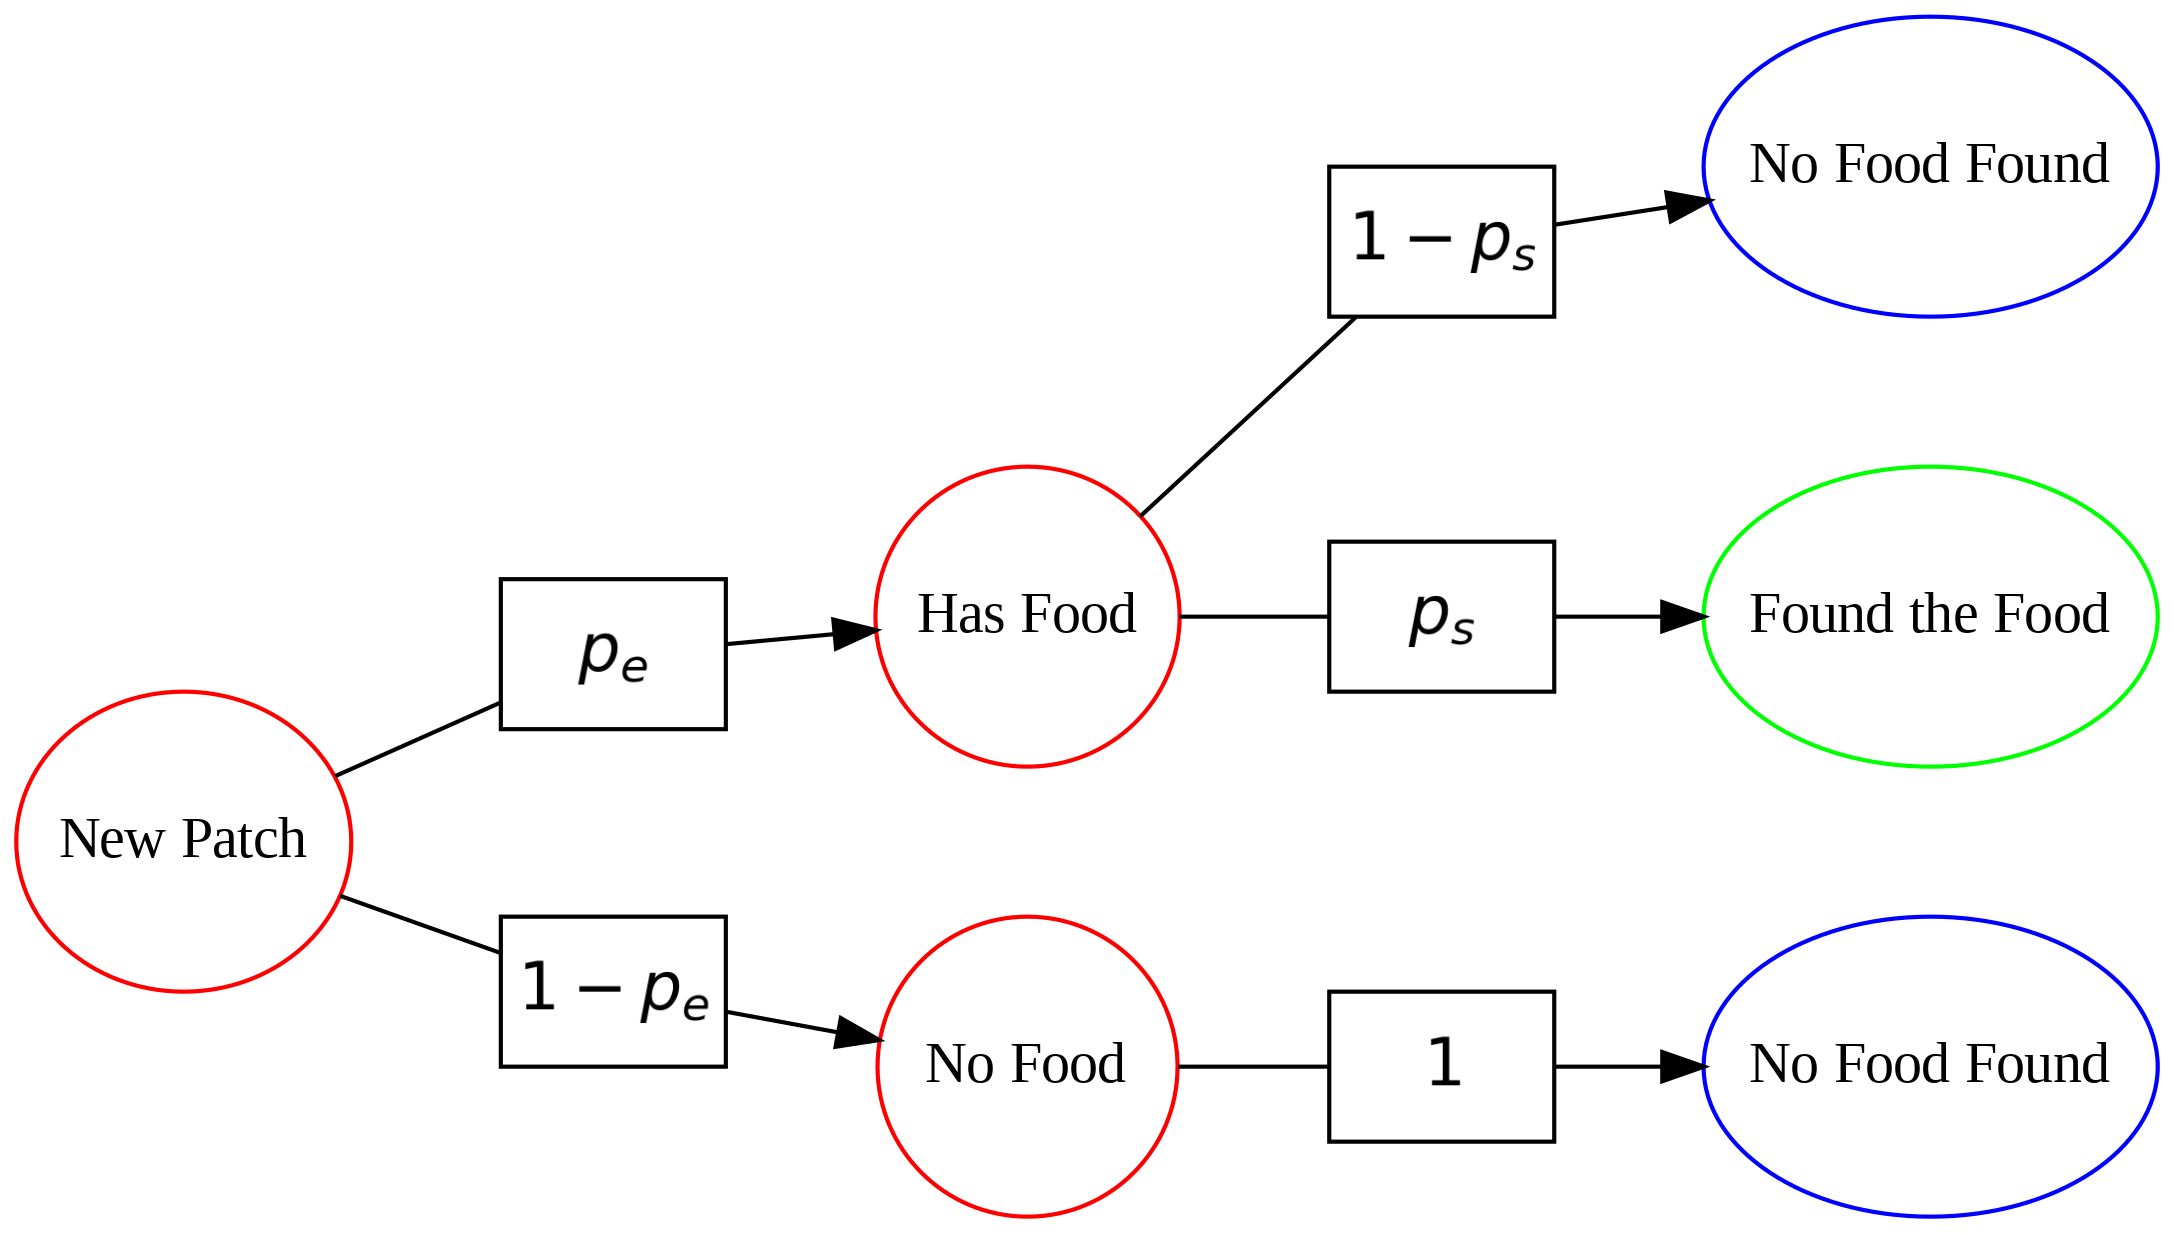

In [20]:
# @markdown **Run This Cell** to visualize these probabilities

nodes_list = ["New Patch", "Has Food", "No Food", "Didn't Find Food", "Found the Food", "No Food to Find"]
edges_list = [("New Patch", "Has Food"), ("New Patch", "No Food"), ("Has Food", "Found the Food"),
              ("Has Food", "Didn't Find Food"), ("No Food", "No Food to Find")]

latex_edge_labels = [
    ("New Patch", "Has Food", "p_e"),
    ("New Patch", "No Food", "1-p_e"),
    ("Has Food", "Didn't Find Food", "1-p_s"),
    ("Has Food", "Found the Food", "p_s"),
    ("No Food", "No Food to Find", "1"),

]

node_colors = {
    "New Patch": "red",
    "Has Food": "red",
    "No Food": "red",
    "Didn't Find Food": "blue",
    "Found the Food": "green",
    "No Food to Find": "blue"
}

node_labels = {
    "Didn't Find Food": "No Food Found",
    "No Food to Find": "No Food Found"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=400)

As we trace a path from the root of the tree ($\text{New Patch}$) to any node, we multiply the probabilities along this path to calculate the likelihood of that specific scenario occurring. This multiplicative approach embodies the 'and' logic of sequential events in our stochastic process. Moreover, when we encounter situations that can arise from multiple paths — such as ($\text{No Food Found}$), which happens in two different scenarios — we sum the probabilities of these paths, employing an 'or' logic to encompass all routes leading to that outcome.

In this visualization, nodes that have the same color are indistinguishable from the perspective of the forager. When a forager arrives at a new patch, maybe the patch has food, maybe it doesn't. The forager doesn't know. To indicate that the forager can't tell these situation apart, these nodes in the graph above are coloured red. Similarly if the forager fails to find food after one round of searching it doesn't know if it failed because there was no food to find in the first place, or if there was actually food there, and it just didn't get it. However, just because the forager can't know with certainty which situation it is in, it is possible to assign probabilities of different situations being the case given knowledge of the underlying stochastic process.

Correctly calculating these probabilities is exactly what we will need to do to figure out the optimal foraging policy. Recall that the goal of the forager is to maximize $ \sum_{t=1}^{T} \mathbb{E}\left[ R_t \right] $, and
$$ \mathbb{E}\left[ R_t \right] = p_s \cdot P(\text{Food Present for Foraging Attempt } t)$$

We know that the probability of food being present at fresh new patch is $p_e$, but what about patches where there has been some history of successful and/or unsucessful foraging? What is the correct way to compute the probability that food is present in these cases?

## **Bayes' Rule**

To start figuring out the probability that food is present at a patch, let's first use the diagram above to just write out the different situations that the forager might find themselves in, and the probability that these situation occur.

| State | Probability State Occurs |
|-----------------------|--------------------------|
| Succesful foraging at new patch | $p_e \cdot p_s$ |
| Failed foraging at new patch with food | $ (1-p_s) \cdot p_e $ |
| Failed foraging at new patch with no food | $1-p_e$ |

That's good, but it doesn't directly tell us what the probability of there being food at the forager's current patch is. For the case where foraging was successful this is straightforward: Either the patch is exhausted and there is no food left with probability $p_x$, or it is not exhausted and food is still present with probability $1-p_x$. For the failed foraging case though the calculation is a little more involved. We derive this now.


| Observable State | Probability Observable State Occurs | Probability of Food Given Observables of the State |
|-----------------------|--------------------------|-------------------------------------|
| Succesful foraging at new patch | $p_e \cdot p_s$ |  $1-p_x$ |
| Failed foraging at new patch | $ (1-p_s) \cdot p_e  + (1-p_e)$ | $\frac{(1-p_s)\cdot p_e}{(1-p_s)\cdot p_e + (1-p_e)}$ |

It is intuitive (to us at least, hopefully to you too) that as the number of failed foraging attempts at a patch increases, the chance that there is no food at the patch also increases. Now obviously, failed foraging attempts do not have any causal impact on the presence or absence of food at the patch (at least not in this model). However, failed foraging attempts do provide **evidence for** the possibility of being at a patch with no food, and **evidence against** the possibility of being at a patch with food. This is because the presence or absence of food at the patch does have a causal impact on foraging success, with foraging success being more likely when food is present and less likely (impossible even in this model) when food is not present. Using this causal relation between the presense/absence of food and foraging success, we can use the observation of foraging success/failure to make an **inference** about whether or not food is present at the patch even though presence/absence is not directly observable.

It turns out that there is one correct way, known as Bayes' rule (or theorem), to make such inferences, i.e. to update beliefs about the world based on observed evidence. In its simplest form Bayes' rule states

$$ P(A|B) = \frac{P(B|A) \cdot P(A)}{P(B)} $$

Here, $A$ and $B$ are events and $P(A|B)$ and $P(B|A)$ are conditional probabilities. Specifically $P(A|B)$ is the probaility of $A$ being the case (or occuring) given that $B$ has occured (or is the case) and $P(B|A)$ is the probability of $B$ being the case if $A$ has occured. To apply Bayes' rule to our situation we let $A$ be the 'event' that food really is present at the new patch (which the forager can't directly observe), and we let $B$ be the 'event' that they don't find any food on their first foraging attempt. This gives us

$$ P(\text{Has Food}| \text{No Food Found}) = \frac{P(\text{No Food Found}|\text{Has Food}) \cdot P(\text{Has Food})}{P(\text{No Food Found})} $$

These values can be read off of our probability tree diagram above giving:

$$ P(\text{Has Food}| \text{No Food Found}) = \frac{(1-p_s) \cdot (p_e)}{(1-p_s) \cdot (p_e) + 1 \cdot (1-p_e)} $$



Another perspective on where this probability is coming from is that we are only considering the pathways in the tree that are possible given the observation of no food found. Then, to figure out the probability of food being at the patch we look at total probability of the paths where there is actually food at the patch (there just one in this example), relative to the total probability of all paths that are possible given the observation.

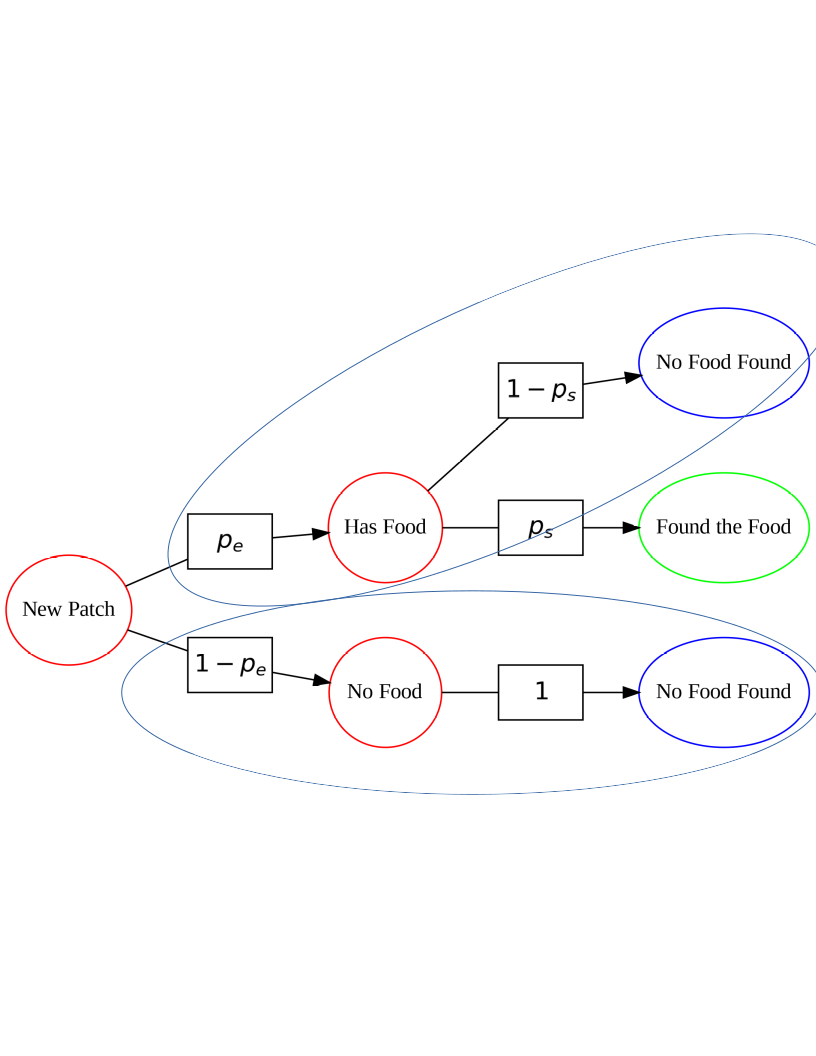

In [21]:
# @markdown Run this cell to display the relevant paths through the probability tree. This is a rough place holder image.

main_url = 'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/sequences/P1C2_OptimizationAndEnvironment/static/marked_up_foraging_prob_tree1.png'
backup_url = 'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/book-review/sequences/P1C2_OptimizationAndEnvironment/static/marked_up_foraging_prob_tree1.png'

# Function to check if URL is accessible
def is_url_accessible(url):
  try:
    response = requests.head(url, allow_redirects=True, timeout=5)
    return response.status_code == 200
  except requests.RequestException:
    return False

# Function to download the PDF
def download_image(url, local_filename):
  try:
    with requests.get(url, stream=True) as r:
      if r.status_code == 200:
        with open(local_filename, 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)
        return True
  except Exception as e:
    print(f"Error downloading file: {e}")
  return False

# Decide which URL to use and download the file
local_image_filename = 'local_marked_up_tree1.png'
if not os.path.exists(local_image_filename):
  if not download_image(main_url, local_image_filename):
    download_image(backup_url, local_image_filename)

# Display the image
Image(filename=local_image_filename)

## Reasoning Exercises: Going Through the Cases

### Case 1. What to do after a failed foraging attempt at a new patch

Now that we have those probabilities computed we can ask, is it better for the forager to stay at a patch where it has just failed to forage, or is it better for it move on to a new patch?

At a new patch the probability of finding food is $$p_e \cdot p_s$$

At a new patch where a forager has been unsuccesful once, the probability of finding food is $$\frac{1-p_s}{(1-p_s) \cdot p_e + (1-p_e)}\cdot p_e \cdot p_s = \frac{1-p_s}{1-p_e \cdot p_s }\cdot p_e \cdot p_s$$

**Quick Math Excercise:**

Given that $0 < p_s < 1$ and $0 < p_e < 1$ convince yourself that $$0 < \frac{1-p_s}{1-p_e \cdot p_s } < 1$$
**Bonus:** Prove this to yourself

**Bonus Answer**
1. If $p_s$ and $p_e$ are both positive and less than one, then their product is also positive and less than one, so is 1 minus their prodcut, that is
$0 < 1-p_e \cdot p_s < 1$
2. Given 1, and that $p_s$ is positve and between zero and one, then $1-p_s$ is positive, and so $0 < \frac{1-p_s}{1-p_e \cdot p_s }$
3. $p_s > p_s \cdot p_e \implies 1 - p_s < 1 - p_s \cdot p_e \implies \frac{1-p_s}{1-p_e \cdot p_s } < 1$

What this tells us is that the probability of finding food at a new patch where the forager has had a failure is always going to be less than the probability of finding food a fresh new patch. Therefore an optimal forager should always move on to a fresh new patch after an immediate failure at a new patch.

### Case 2. What to do after succesful foraging

In order to figure this out we're going to have to expand our probability tree out one step.

In [ ]:
# @markdown Run this cell to visualize the probability tree

nodes_list = ["New0", "Has Food0", "No Food0",
              "Didn't Find Food", "Found the Food",
              "No Food to Find",
              "New1", #"Has Food1", "No Food1",
              "New2", #"Has Food2", "No Food2",
              "Still Food", "Food Ran Out"]
edges_list = [("New0", "Has Food0"), ("New0", "No Food0"), ("Has Food0", "Found the Food"),
              ("Has Food0", "Didn't Find Food"), ("No Food0", "No Food to Find"),
              ("Didn't Find Food", "New1"),
              #("New1", "Has Food1"), ("New1", "No Food1"),
              ("Found the Food", "Still Food"), ("Found the Food", "Food Ran Out"),
              ("No Food to Find", "New2"),
              #("New2", "Has Food2"), ("New2", "No Food2")
              ]


latex_edge_labels = [
    ("New0", "Has Food0", "p_e"),
    ("New0", "No Food0", "1-p_e"),
    ("Has Food0", "Didn't Find Food", "1-p_s"),
    ("Has Food0", "Found the Food", "p_s"),
    ("No Food0", "No Food to Find", "1"),
    ("No Food to Find", "New2", "1"),
    ("Didn't Find Food", "New1", "1"),
    ("Found the Food", "Still Food", "1-p_x"),
    ("Found the Food", "Food Ran Out", "p_x"),
    #("New1", "Has Food1", "p_e"),
    #("New1", "No Food1", "1-p_e"),
    #("New2", "Has Food2", "p_e"),
    #("New2", "No Food2", "1-p_e")
]

node_colors = {
    "New0": "red",
    "Has Food0": "red",
    "No Food0": "red",
    "New1": "red",
    "Has Food1": "red",
    "No Food1": "red",
    "New2": "red",
    "Has Food2": "red",
    "No Food2": "red",
    "Didn't Find Food": "blue",
    "Found the Food": "green",
    "No Food to Find": "blue",
    "Still Food": "green",
    "Food Ran Out": "green"
}

node_labels = {
    "New0": "New",
    "New1": "New",
    "New2": "New",
    "Has Food0": "Has Food",
    "Has Food1": "Has Food",
    "Has Food2": "Has Food",
    "No Food0": "No Food",
    "No Food1": "No Food",
    "No Food2": "No Food",
    "Didn't Find Food": "No Food Found",
    "No Food to Find": "No Food Found",
    "Finally Found Food": "Found the Food",
    "Still Food": "More Food There",
    "Still No Food to Find": "Still No Food"

}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=500)

So after successful foraging the probability that there is still food at the patch is $1-p_x$. Thus, after a succsfull forage at a new patch if $1-p_x > p_e$ it is better to stay and continue foraging, but if $1-p_x < p_e$ then it is better to move on to a fresh patch.

### Case 3. What to do after one failed foraging attempt following successful foraging

In cases where $1-p_x > p_e$, i.e. food persisting at a patch is more likely than finding a new patch with food, and it makes sense for the forager to forage again at the same patch after a successful foraging attempt. In these cases, we then need to know what a forager should do if this subsequent attempt fails. Again, let's expand the visualization to help us think this through. To focus in on our particular question we will use the "$\text{Found the Food}$" node as the root node of this next probability tree.

In [ ]:
# @markdown Run this cell to visualize the probability tree

nodes_list = [
  "Found the Food",
  "Still Food", "Food Ran Out",
  "Found More Food", "Didn't Find Food", "No Food to Find"
]
edges_list = [
  ("Found the Food", "Still Food"),
  ("Found the Food", "Food Ran Out"),
  ("Still Food", "Found More Food"),
  ("Still Food", "Didn't Find Food"),
  ("Food Ran Out", "No Food to Find"),
]

latex_edge_labels = [
  ("Found the Food", "Still Food", "1-p_x"),
  ("Found the Food", "Food Ran Out", "p_x"),
  ("Still Food", "Found More Food", "p_s"),
  ("Still Food", "Didn't Find Food", "1-p_s"),
  ("Food Ran Out", "No Food to Find", "1"),
]

node_colors = {
  "Found the Food": "green",
  "Still Food": "green",
  "Food Ran Out": "green",
  "Found More Food": "green",
  "Didn't Find Food": "blue",
  "No Food to Find": "blue",
}

node_labels = {
  "Still Food": "More Food There",
  "Didn't Find Food": "No Food Found",
  "No Food to Find": "No Food Found"
}


output_path = create_and_render_graph(nodes_list, edges_list, latex_edge_labels,
                                      node_colors=node_colors,
                                      node_labels=node_labels)
Image(output_path, height=500)

This should look very familiar. This is basically the same situation we had previously where the forager can't definatively tell the difference between a failed foraging attempt caused by there not being anything to find, and a failed foraging attempt where the patch has food and the forager just didn't find it. Just as before Bayes' rule allows us to compute how likely it is that there is still food at the patch when an unsuccessful foraging attempt follows a successful foraging event. Specifically

$$ P(\text{More Food}| \text{No Food Found}) = \frac{P(\text{No Food Found}|\text{More Food}) \cdot P(\text{More Food})}{P(\text{No Food Found})} $$

Again, these values can be read off of our probability tree diagram above giving:

$$ P(\text{More Food}| \text{No Food Found}) = \frac{(1-p_s) \cdot (1-p_x)}{(1-p_s) \cdot (1-p_x) + p_x} $$

Given this, and the fact that the forager should always forage in the place most likely to have food, it should move to a fresh new patch if and only if
$$\frac{(1-p_s) \cdot (1-p_x)}{(1-p_s) \cdot (1-p_x) + p_x} < p_e $$

We haven't yet given any specific values for the parameters of this proccess, but if we did have some we could plug them into this formula to see if foraging after one failed foraging attempt following successful foraging is a good or a bad idea. Let's say
* $p_e=0.3$
* $p_s=0.6$
* $p_x=0.2$

These just happen to be the parameter values used in the simulations earlier.
Plugging those values into our formulae we have that the probability of food at the current patch is roughly $0.642...$ which is greater than $p_e=0.4$ so for this particular parameter set, foraging again at the same patch with one failure after a success is optimal.

In [ ]:
# Probability of there still being food at the current patch after one failed attempt following a successful attempt
p_e = 0.3
p_s = 0.6
p_x = 0.2
((1 - p_s) * (1 - p_x)) / ((1 - p_s) * (1 - p_x) + p_x)

### Case 4. What to do after $n$ failed foraging attempts following successful foraging

We know that after a single failed foraging attempt at a new patch the forager should move on. The intuition here is that a failed foraging attempt gives evidence for the new patch being one with no food, so better to just start again at a fesh patch. (Note that there are no travel costs here, if there were things would be trickier.) Conversely, after having found food at a patch, if exhaustion is relatively unlikely, then the evidence provided by a failed attempt might still not be enough to counter the evidence of a previous success. So, for some parameter values, trying again at the same patch is the best thing to do.

Expanding these probability trees is fun, but could become a bit tedious if we had to do it a lot. However, we do need some way to compute this more general quantity:

$$ P(\text{More Food}| \text{No Food Found } n \text{ Times}) = \frac{P(\text{No Food Found } n \text{ Times}|\text{More Food}) \cdot P(\text{More Food})}{P(\text{No Food Found } n \text{ Times})} $$

**Probability Exercise**

Plug the correct values into the formula above.

Answer:

$$ P(\text{More Food}| \text{No Food Found } n \text{ Times}) = \frac{(1-p_s)^n \cdot (1-p_x)}{(1-p_s)^n \cdot (1-p_x) + p_x} $$

Then for our given parameter values we can see how the liklihood of there being food at the patch diminishes with each unsuccessfull foraging attempt, until it passes the threshold probability $p_e$ where it makes sense to start foraging at a new patch

In [ ]:
p_e = 0.3  # Probability of food being present at a new patch
p_s = 0.6  # Probability of foraging success
p_x = 0.2  # Probability of patch exhaustion after success

def prob_still_food_after_n_fails(n, p_s, p_x):
  return ((1 - p_s) ** n * (1 - p_x)) / ((1 - p_s) ** n * (1 - p_x) + p_x)

# Calculating probabilities different n values
n_values = np.arange(0, 6)  # From 0 to 5
prob_values = [prob_still_food_after_n_fails(n, p_s, p_x) for n in n_values]

# Plotting the probabilities
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(n_values, prob_values, marker='o', color='blue', label='At Current Patch')
ax.axhline(y=p_e, color='green', linestyle='--', label='At New Patch')

ax.set_title('Probability Food Present Conditional on n Foraging Failures')
ax.set_xlabel('Number of Times No Food Found (n)')
ax.set_ylabel('Probability of Food at Patch')
ax.grid(False)
ax.legend()
remove_ip_clutter(fig)

plt.show()

Looking at this figure it is clear that even after 2 failures, for these parameter values at least, it is still better to forage at the current patch. However, after 3 consecutive foraging failures enough evidence against there being food present at the current patch has accumulated and its time for the forager to move on to a new patch.

## Math Exercise: Optimal Thresholds

Summarizing our analysis thus far.
* No matter what the parameter values, a single foraging failure at a new patch should prompt the forager to move on to a new patch (provided there is an abundant supply of fresh patches, e.g. more new patches than there are foraging rounds). This is because a single foraging failure at a new patch provides evidence for their being no food at that patch, making a fresh patch preferable to foraging again in the same place.
* If patch exhaustion through foraging is unlikely relative to the baseline probability of food presnce at a fresh patch, then having found food at a patch provides evidence for the continued presense of food at that same patch. Specifically if $1-p_x < p_e$, then foraging at a patch where food was just found is the best thing to do. Conversely if patch exhaustion through foraging is likely relative to the baseline probability of food presence at a fresh patch, then having found food at a patch provides evidence for the absence of food at that same patch. Moving to a fresh patch after successuful foraging is  if $1-p_x > p_e$ is the best thing to do.
* In the case where $1-p_x < p_e$ and so continued foraging at the same patch after success is good, subsequent failed foraging attempts provide evidence that the patch was indeed exhausted and no food is present. The probability of food being present after $n$ failed foragin attempts is
$$ \frac{(1-p_s)^n \cdot (1-p_x)}{(1-p_s)^n \cdot (1-p_x) + p_x} $$
When this quantity is greater than $p_e$ continued attempts at the same patch is the best thing to do, but when this quantity is less than $p_e$ it is time to move on to a new patch.

Taking this one step further we can algebrically solve for $n$ as a function of the parameters to determine what the optimal policy is for any given set of parameters.

**Exercise** Algebrically manipulate the expression
$$ \frac{(1-p_s)^n \cdot (1-p_x)}{(1-p_s)^n \cdot (1-p_x) + p_x} > p_e$$
To determine the maximum number $n$ of consecutive foraging failures after a successful foraging attempt where it is still optimal to continue foraging at the same patch.

Answer:
$$
\begin{align}
(1-p_s)^n \cdot (1-p_x) &> p_e \cdot ((1-p_s)^n \cdot (1-p_x) + p_x) \\
(1-p_e)\cdot (1-p_s)^n \cdot (1-p_x) &> p_e \cdot p_x \\
(1-p_s)^n &> \frac{p_e \cdot p_x}{(1-p_e)\cdot(1-p_x)} \\
n \ln(1-p_s) &> \ln \left( \frac{p_e \cdot p_x}{(1-p_e)\cdot(1-p_x)} \right) \\
n &< \frac{\ln(p_e) + \ln(p_x) - \ln(1-p_e) - \ln(1-p_x)}{\ln(1-p_s)}
\end{align}
$$
So when
$$
n \leq \left\lfloor \frac{\ln(p_e) + \ln(p_x) - \ln(1-p_e) - \ln(1-p_x)}{\ln(1-p_s)} \right\rfloor
$$
The forager should keep trying the same patch.

So this analysis seems sound, but let's check that when we use these supposedly optimal thresholds, our forager does indeed perform better than when using other sub-optimal threshold foraging rules. For the parameter values
* $p_e=0.3$
* $p_s=0.6$
* $p_x=0.2$

This gives us


In [ ]:
p_e = 0.3
p_s = 0.6
p_x = 0.2
np.floor((np.log(p_e) + np.log(p_x) - np.log(1-p_e) - np.log(1-p_x)) / np.log(1-p_s))

So for these parameters, the forager should try again after two fails, but move on to a fresh patch after the third, and never forage again after a failed attempt at a new patch. Run the cell below to check performance for different thresholds. Note that the threshold is maximum number of consecutive misses before the forager moves on. So the optimal threshold is $0$ for new patches and $2$ for patches with a prior success.

In [ ]:
# @markdown **Run This Cell** to evaluate the expected value of this foraging scenario under different threshold combinations

class ValueHeatmapWidget:

  def __init__(self, p_e, p_x, p_s, max_foraging_attempts):
    self.rng = np.random.default_rng()
    self.p_e = p_e
    self.p_x = p_x
    self.p_s = p_s
    self.max_foraging_attempts = max_foraging_attempts
    self.heatmap_data = np.zeros((12, 12))
    self.fig, self.ax = plt.subplots(figsize=(10, 8))
    self.ax.set_xlabel('Successful Forage Threshold')
    self.ax.set_ylabel('New Patch Threshold')
    self.ax.set_xlim(-0.5, 5.5)
    self.ax.set_ylim((6.5, -0.5))
    self.ax.xaxis.tick_top()
    self.ax.xaxis.set_label_position('top')
    self.ax.spines['top'].set_visible(True)
    self.ax.spines['right'].set_visible(True)
    self.ax.spines['bottom'].set_visible(True)
    self.ax.spines['left'].set_visible(True)
    remove_ip_clutter(self.fig)
    #y_ticks = self.ax.get_yticks().tolist()
    # Adjust the labels
    #y_labels = [str(int(tick+1)) for tick in y_ticks if 0 <= tick < 11]
    # Set the new labels without altering the tick positions
    #self.ax.set_yticklabels(y_labels)
    self.text_annotations = []

    # Create sliders
    self.tau_new_slider = widgets.IntSlider(min=0, max=5, step=1, value=2)
    self.tau_eat_slider = widgets.IntSlider(min=0, max=5, step=1, value=2)
    self.tau_new_label = widgets.Label(value="New Patch Threshold")
    self.tau_eat_label = widgets.Label(value="Successful Eating Threshold")
    self.tau_new_box = widgets.VBox([self.tau_new_label, self.tau_new_slider])
    self.tau_eat_box = widgets.VBox([self.tau_eat_label, self.tau_eat_slider])

    # Create compute button
    self.compute_button = widgets.Button(description="Compute Value")
    self.compute_button.on_click(self.update_plot)

    # Put the display together with the VBoxes and button
    self.sliders = widgets.VBox([self.tau_new_box, self.tau_eat_box, self.compute_button])
    self.final_display = widgets.HBox([self.sliders, self.fig.canvas])

  def update_cax(self, data):
    if hasattr(self, 'cax'):
      self.cax.set_data(data)
      self.cax.autoscale()
      self.colorbar.remove()
    else:
      self.cax = self.ax.matshow(data, cmap='gray_r')

    self.colorbar = self.fig.colorbar(self.cax, ax=self.ax)

  def update_plot(self, change=None):
    tau_new = self.tau_new_slider.value
    tau_eat = self.tau_eat_slider.value
    pfg = PatchyForagingGame(batch_size=1000,
                         food_patch_prob=self.p_e,
                         food_extinct_prob=self.p_x,
                         forage_success_prob=self.p_s,
                         max_foraging_attempts=self.max_foraging_attempts,
                         food_regen_prob=0,
                         rng=self.rng)
    stp = SimpleThresholdPlayer(pfg, critter_index=1,
                                threshold_new=tau_new,
                                threshold_known=tau_eat)
    result = pfg.play_game([stp])
    score = np.mean(result['scores'])

    # Update heatmap_data
    self.heatmap_data[tau_new, tau_eat] = score

    # Plot
    self.update_cax(self.heatmap_data)

    for txt in self.text_annotations:
      txt.remove()
    self.text_annotations.clear()

    # Annotate heatmap
    for i in range(11):
      for j in range(12):
        c = self.heatmap_data[j, i]
        if c != 0:
          txt = self.ax.text(i, j, f"{c:.2f}", va='center', ha='center', color='w' if c > 0.5 else 'k')
          self.text_annotations.append(txt)

    self.fig.canvas.draw()

# Using the class
vh_widget = ValueHeatmapWidget(p_e=0.3, p_x=0.2, p_s=0.6,
                               max_foraging_attempts=20)
display(vh_widget.fig.canvas)
clear_output()
display(vh_widget.final_display)

Hopefully our optimal strategy is really seeming optimal.

Two things to notice about what we've done here:
1. Unlike previous optimization processes in the book where we've tried different parameters and evaluated them until eventually we've found good parameters, here we reasoned about the properties of the optimal strategy and then deduced what it should be. No algorithms, no function evaluations, just thinking.
2. With an algorithmic optimization process, the algorithm needs to be run, and a different optimal policy found, each time the parameters of the underlying problem change. Here, we've derived the optimal strategy as a function of the parameters. Thus for any set of parameters, we can instantly determine the optimal strategy, without needing to re-run the optimization process. Very efficient!

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# **1.2.3.3 Propose and Test versus Reasoning**

Now that we've reasoned about policies and used our analysis to determine the optimal policy let's see how our old standby approach 'Propose and Test' does with this same problem.

In [ ]:
# @title Propose and Test
# @markdown Run this cell to use the propose and test method to find good parameters for this patchy foraging problem.

def evaluate(params, game):
  stp = SimpleThresholdPlayer(game, critter_index=1, threshold_new=params[0],
                              threshold_known=params[1])
  result = game.play_game([stp])
  return(np.mean(result['scores']))


def patchy_propose_and_test(batch_size=1000,
                            initial_params=None,
                            max_rejected=200,
                            verbose=True):

  game = PatchyForagingGame(batch_size=batch_size,
                            food_patch_prob=0.3,
                            food_extinct_prob=0.2,
                            forage_success_prob=0.6,
                            max_foraging_attempts=20,
                            food_regen_prob=0)
  tested_params_dict = {}
  # Initialize parameters
  if initial_params is None:
    initial_params = 5*np.ones(2, dtype=int)
  best_params = initial_params
  best_avg_score = evaluate(best_params, game)
  print(f"Initial score: {best_avg_score}")
  rejected_count = 0
  total_tests = 0  # Number of iterations
  if verbose:
    intermediate_params = []
    intermediate_params.append(best_params)
    intermediate_values = [best_avg_score]
    iterations = [0]

  # Propose-and-test loop
  start_time = time.time()
  while rejected_count < max_rejected:
    total_tests +=1
    # Propose new parameters: sample custom list of small discrete steps
    # centered at best_params
    delta_dim1 = np.random.choice([-2, -1, 0, 1, 2])
    delta_dim2 = np.random.choice([-2, -1, 0, 1, 2])
    delta_params = np.array([delta_dim1, delta_dim2])
    proposal_params = best_params + delta_params
    # Ensure that the values for the first dimension don't go below 0
    proposal_params[0] = max(0, proposal_params[0])
    proposal_params[1] = max(1, proposal_params[1])

    if tuple(proposal_params) in tested_params_dict.keys():  # Step 2: Check if the proposed parameters have been tested before.
      #print('already tested' + str(proposal_params))
      rejected_count += 1
      continue

    #print('now testing' + str(proposal_params))
    avg_score = evaluate(proposal_params, game)
    tested_params_dict[tuple(proposal_params)] = avg_score

    if avg_score > best_avg_score:
      best_params = proposal_params
      best_avg_score = avg_score
      if verbose:
        print('best params so far:')
        display(best_params)
        print(f"Best score so far: {best_avg_score}")
        print(f"Found after a total of {time.time() - start_time:.2f} seconds")
        rejected_count = 0
    else:
      rejected_count += 1

  end_time = time.time()
  elapsed_time = end_time - start_time
  iterations.append(total_tests)

  if verbose:
    # Print the best found parameters and score
    print("Best Parameters:", best_params)
    print("Best Average Score:", best_avg_score)
    print("Parameter combinations tested:", total_tests)
    print(f"Time taken for the optimization loop: {elapsed_time:.2f} seconds")
    return (best_params, best_avg_score, tested_params_dict)
  else:
    return best_params, best_avg_score

best_params, best_score, tested_params_dict = patchy_propose_and_test()

Questions:
1. Did the propose and test method using simulation based evaluation find the same optimal parameters as we did using analytical policy evaluation? [Answer](## "Using simulation based evaluation sometimes finds the true optimal parameters as determined using analytical policy evaluation, but due to the stochastic nature of this evaluation method sometimes propose and test only finds parameters that are close to optimal.")
2. What about the best scores reported by the propose and test algorithm using simulation based evaluation, are these higher, lower or about the same as determined using an analytical approach? [Answer](## "The best scores reported by the propose and test algorithm using simulation based evaluation are usually close to the true expected value, but again due to stochastic evaluation they are never exactly the same.")

## **Multiple Perspectives on Optima**

In this sequence we have looked at the same patchy foraging problem in two different ways.

The first perspective was to interact with and observe a 'full' simulation of the problem, where an organism plays through rounds of a game according to some policy and receives a score. This is how we have approached everything so far in this book. Although this perspective and this game are highly simplified compared to lived reality, this general approach of 'run it and see' is exactly what evolution is doing. Variations on the policy emerge due to recombination and mutation, organisms live their lives, and the effectiveness of their policy is 'evaluated' via natural selection, roughly as the number of offspring surviving to the next generation. Importantly, the evolutionary selective process needs no analytic insight into the nature of the environment in which organisms are born and execute their policies. It is a black box, 'run it and see' approach.

The second perspective, which we introduced here was to think about the nature of the problem, to write out a symbolic mathematical expressions that described the problem, and then through deductive reasoning arrive at an exact analytical method of determining the optimal policy for this problem.

These perspectives, for the most part, converged on the same optimal policy. Why is this? The optimal solution of a problem is inherent to the problem itself, not the method used to find the solution. Thus, different optimization approaches applied to the same problem, will arrive at the same conclusions, to the extent that each different optimization approach is effective. This insight has been a powerful tool in understanding evolved behaviours and traits, with optimality models helping to explain a staggering array of animal behaviours (and the behaviour of all kinds of life). These are just a few examples:

1. **Humming Bird Foraging**: Many animals are under selection pressure to maximize their net energy intake while minimizing the risk. The sequence in which hummingbirds feed on the flowers in their territory can be understood as minimizing flight distance and thus saving energy and time. This behavior exemplifies an energy-efficient strategy that boosts survival and reproductive chances.

2. **Web Building in Spiders**: Considering the metabolic cost of producing silk, spiders build their webs to capture the most prey while using the least amount of material. Different spider species, depending on their ecological niche, have optimized their web designs accordingly - from the dense tangle webs of the funnel-web spiders to the expansive orb webs of garden spiders.

3. **Echolocation in Bats**: Bats optimize the frequency and duration of their echolocation calls based on their environment and prey type. In cluttered environments, bats often use shorter frequency-modulated calls to detect nearby objects. However, in open spaces, they employ longer calls for detection over a more extended range. This behavioral adaptation can be viewed as an optimization problem where bats adjust their call parameters for maximum prey detection.

4. **Migratory Paths of Birds**: Migratory birds traverse vast distances, optimizing their routes to conserve energy, avoid predators, and capitalize on food sources. For example, the Arctic tern, traveling from its Arctic breeding grounds to the Antarctic coast, chooses a path that, although not the shortest, exploits prevailing wind patterns and abundant food sources.

5. **Root Architecture in Plants**: The way a plant structures its root system is crucial for both nutrient uptake and stability. For instance, in areas prone to drought, plants like mesquite trees invest in deep taproots that reach far into the soil, tapping into groundwater sources. In contrast, plants in nutrient-rich but unstable environments, like riverbanks, invest in expansive but shallow root systems to maximize nutrient absorption while anchoring themselves against fast-moving water.

6. **Leaf Orientation and Sun Tracking**: Sunflower fields during a sunny day offer a mesmerizing sight: rows of flowers all facing the sun. This behavior, known as heliotropism, allows the plant to maximize sunlight absorption. By tracking the sun across the sky, sunflowers optimize photosynthesis rates. Similarly, desert plants like the creosote bush have small, vertically-oriented leaves, reducing their exposure to the intense midday sun and minimizing water loss due to transpiration.

7. **Thermoregulation in Reptiles**: Cold-blooded reptiles, such as lizards and snakes, primarily thermoregulate through behaviour (not metabolically, like warm-blooded mammals and birds). Take the diurnal behavior of desert lizards: by basking in the morning sun, they quickly elevate their body temperature, optimizing their physiological functions for the day ahead. As midday approaches with its peak heat, these reptiles retreat to cooler shades or burrows, ensuring they don't overheat. This can be understood as an optimization strategy, balancing the need for warmth to maintain metabolic rates with the imperative to avoid lethal high temperatures.

8. **Camouflage and Coloration**: The appearance of many plants and animals appearances can be understood as optimization for avoiding detection. Consider the peppered moth in industrial England. Historically, the majority of these moths were light-colored, blending seamlessly with the lichen-covered trees. However, during the Industrial Revolution, pollution darkened the trees, giving an advantage to rare dark-colored moths. As these darker moths thrived in their new environment, their numbers surged, demonstrating a rapid optimization of camouflage in response to environmental changes.



Each of the examples above takes an 'Ultimate' evolutionary functional perspective to explain behaviours or traits. However, this is but one of four perspectives from which to understand a behaviour.

## **Different Kinds of Understanding: Tinbergen's Four Questions**

Building on work by Julian Huxley, Niko Tinbergen described four "whys" or perspectives for understanding an observed behaviour (adapted from Aristotle's four causes). These continue to ground and inform interdisciplinary work across the behavioural sciences.

1. **Mechanistic** (Sensory and Biophysical Causes): This approach seeks to understand the immediate causes of a behaviour from the sensory input that elicits it through to the biophysical processes of the organism which produce the behaviour in response to a particular environmental input. While the 'Ultimate' perspective might explain why a bird sings in terms of its evolutionary function, e.g. to attract a mate, the mechanistic perspective looks at how a bird's vocal cords, brain circuits, and hormones function together to produce the song in response to certain environmental conditions, but not others.

2. **Ontogenetic** (Developmental Causes): This perspective examines how a behavior develops in an individual over their lifetime. It encompasses aspects of both learning and maturation. For example, while many birds are born with the inherent capability to sing, they often refine their songs through interactions with their environment and other birds, improving their repertoire and accuracy over time.

3. **Functional** (Adaptive Evolutionary Causes): This is the perspective we have focused on so far. It seeks to understand behavior in terms of the selective advantage it confers to the organism. How does the behavior increase the chances of survival and reproduction? The hummingbird foraging and the spider web-building examples fit into this category, showcasing behaviors that have been optimized over generations for increased fitness.

4. **Phylogenetic** (Historical Evolutionary Causes): This perspective traces the behavior's lineage through evolutionary history. Why does a particular species exhibit this behavior, but not another? Did the common ancestor of these species also exhibit this behavior? How has evolutionary history set the conditions and constraints on which adaptive new forms are possible? For instance, the vertebrate eye (including the human eye) has a blind spot, whereas octopus eyes do not. In each of these two lineages, the eye originally developed in one of two distinct ways. Once this initial development program for the vertebrate eye was set, there were no intermediate forms that were both adaptive and would have enabled it to evolve without a blind spot.

Scientific work can be done using one, several, or all of these perspectives combined. No single perspective is inherently better or more important. What is deeply valuable though, for any project within the life sciences, is knowing which kinds of understanding are being aimed at, and how work from the other perspectives might guide and constrain understanding in the area(s) of focus.

In this book we will often take a functional perspective. However, understanding how phylogeny, ontogeny, and mechanism constrain and determine the optimization problems to be analyzed is critical to the relevance and validity of the functional perspective.

Where does this four-perspective framework situate neuroscience within the broader behavioral sciences? Traditionally, neuroscience has largely been part of a mechanistic understanding of behaviour, i.e. how do the brain circuits compute and produce muscles activations that generate appropriate behaviour given environmental inputs. Learning is also obvious and important part of what brains do. To the extent that neuroscience research is focused on learning, i.e. adaptive neural plasticity, it is also a part of the ontogenetic understanding of behaviour.

We believe that new kinds of understanding, in particular, understanding grounded in an ontogenetic and functional perspective, have recently become possible based on new insights into the optimization of high-dimensional systems emerging from Machine Learning research. At the same time, again based on insights from Machine Learning research, we believe that neuroscience as a field is approaching the natural limits of what can be comprehended about the brain and its behavioural outputs in a certain mechanistic sense. Given this, we advocate a shift away from attempts at 'circuit diagram understanding' of how brains compute and determine behaviour. In the field of ML 'circuit diagrams' of large complicated models that generate adaptive behaviour in complex environments are readily available for comprehensive and detailed inspection, all within completely controllable artificial environments. Yet, despite this total visibility, a satisfactory 'understanding' of how these many parameter systems compute and determine behaviour, so called 'interpretability', is so far largely absent. Conversely, ML researchers do have understanding of the learning algorithms that produce these complex and largely inscrutable models, i.e. the ontogeny of the these models, and the mechanisms of this ontogeny are relaitvely clear. It is for this reason that we encourage a 'learning first' approach to neuroscience, focused on understanding the adaptive neural plasticity dynamics governing brain development and the ongoing learning and behavioural plasticity that this supports. We posit that this, together with the mechanistic underpinnings of these learning dynamics, all considered in light of the overarching adaptive functional role of the brain, will lead to a predictive and integrative understanding of the brain.

In the next chapter, we will focus primarily on evolution, aiming to elucidate the general adaptive functions of the brain. Then, in subsequent parts of the book we will connect different classes of machine learning algorithms to the specific adaptive challenges they can address in the context of the brain. In each case we will show how insights from effective ML algorithms on a specific class of adaptive problem can both integrate existing empirical neuroscience work and inform future empirical work, within a 'learning first' perspective on brain function.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")